In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def read_channels(path, n=8, plot=False, ylim=[1.0,2.0]):
    arr_ts = []
    for i in range(n):
        raw_data = pd.read_csv(path + '0%d.dat' % (i+1), delimiter=',', header=None)
        ts = pd.Series(list(raw_data[1]), pd.to_datetime(raw_data[0], unit='ms', utc=True).dt.tz_convert('US/Eastern'))
        arr_ts.append(ts)
        if plot == True:
            plt.subplot(n, 1, i+1)
            plt.ylim(ylim)
            ts.plot(figsize=(15, 15))
    return arr_ts

def clip_channels(arr, startTime, endTime, plot=False, ylim=[1.0,2.0], xlabel='Time(s)', ylabel='Energy(W)'):
    arr_clip=[]
    for i in range(len(arr)):
        mask = (arr[i].index > startTime) & (arr[i].index < endTime)
        arr_clip.append(arr[i][mask])
        if plot == True:
            plt.subplot(len(arr), 1, i+1)
            plt.ylim(ylim)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            arr[i][mask].plot(figsize=(15, 15))
    return arr_clip

def stack_channels(arr):
    minlen = 65536
    for i in arr:
        minlen = min(minlen, len(i))
    arr_matrix = np.array([0]*minlen)
    for i in range(len(arr)):
        arr_matrix = np.vstack((arr_matrix, np.array(arr[i][0:minlen])))
    arr_matrix = np.transpose(arr_matrix[1:,:])
    return arr_matrix

def pca_eigenvalues(arr, n=8, plot=False):
    from sklearn.decomposition import PCA
    pca = PCA(n_components = n, whiten=True)
    XND = pca.fit_transform(arr)
    if plot == True:
        import matplotlib.pyplot as plt
        plt.figure(figsize = (15, 3))
        plt.plot(pca.explained_variance_ratio_, '*-')
        plt.xlabel('Component Index')
        plt.ylabel('Explained Variance Ratio')
        plt.figure(figsize = (15, 3))
        plt.plot(pca.singular_values_, '*-')
        plt.xlabel('Component Index')
        plt.ylabel('Singular Value')
    return pca.explained_variance_ratio_, pca.singular_values_

def covariance_matrix(arr, print_matrix=False):
    cov = np.corrcoef(np.transpose(arr))
    if print_matrix == True:
        float_formatter = lambda x: "%.2f" % x
        np.set_printoptions(formatter={'float_kind':float_formatter})
        np.set_printoptions(threshold=np.nan)
        print(cov)
        plt.figure()
        plt.imshow(cov)
        
def remove_peaks(arr_with_peaks, threshold=1.4, plot=False):
    from scipy.signal import find_peaks
    arr_without_peaks = arr_with_peaks
    peaks, _ = find_peaks(arr_with_peaks, height=threshold)
    if plot == True:
        plt.figure(figsize=(15, 10))
        plt.subplot(2,1,1)
        plt.plot(arr_with_peaks)
        plt.ylim([1.0, 3.0])
        plt.plot(peaks, arr_with_peaks[peaks], "x")
    #print(arr_with_peaks.shape, peaks)
    for i in range(len(peaks)):
        arr_without_peaks[peaks[i]] = (arr_without_peaks[peaks[i]-1] + arr_without_peaks[peaks[i]+1]) * 0.5
    if plot == True:
        plt.subplot(2,1,2)
        plt.plot(arr_without_peaks)
        plt.ylim([1.0, 3.0])
    return (arr_without_peaks, len(peaks))

[[ 1.    -0.052 -0.079 -0.01  -0.052  0.05  -0.136  0.21 ]
 [-0.052  1.     0.184  0.132 -0.074 -0.095 -0.117 -0.074]
 [-0.079  0.184  1.     0.064 -0.052 -0.095 -0.097 -0.004]
 [-0.01   0.132  0.064  1.    -0.092 -0.016 -0.106 -0.108]
 [-0.052 -0.074 -0.052 -0.092  1.     0.277 -0.129  0.036]
 [ 0.05  -0.095 -0.095 -0.016  0.277  1.    -0.076 -0.03 ]
 [-0.136 -0.117 -0.097 -0.106 -0.129 -0.076  1.    -0.092]
 [ 0.21  -0.074 -0.004 -0.108  0.036 -0.03  -0.092  1.   ]]


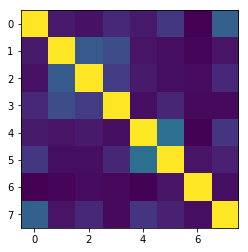

In [369]:
covariance_matrix(np.transpose(arr), print_matrix=True)

(array([0.209, 0.16 , 0.155, 0.13 , 0.117, 0.103, 0.083, 0.043]),
 array([1.867, 1.631, 1.607, 1.471, 1.395, 1.308, 1.178, 0.85 ]))

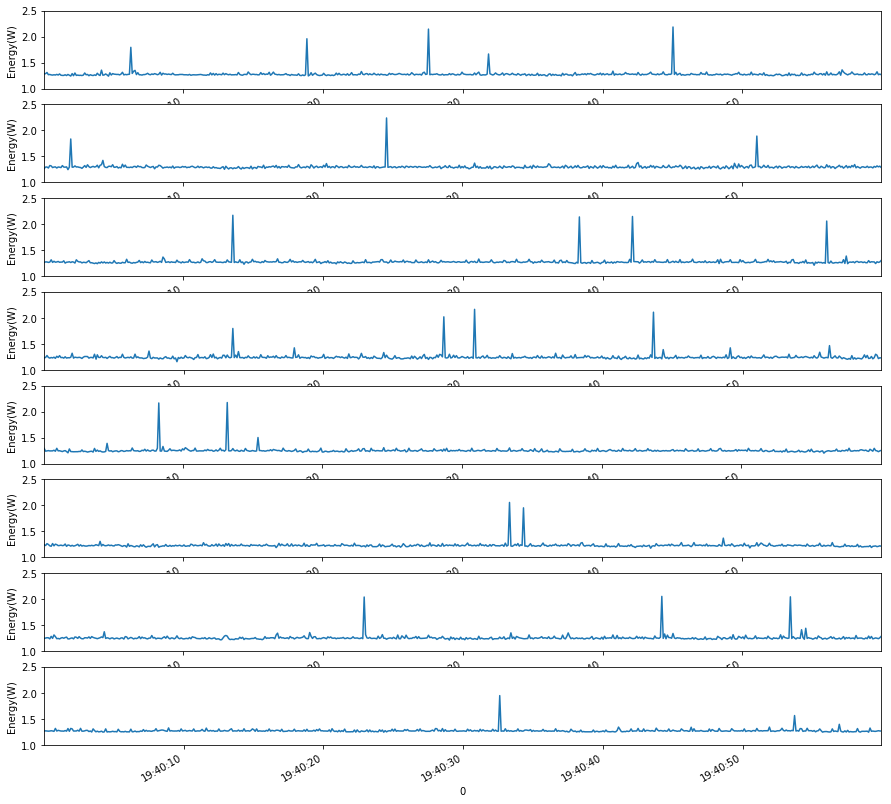

In [374]:
arr = read_channels('../raw_data/20190226/mesh_clean_2_monitor', plot=False)
arr_clip = clip_channels(arr, startTime='2019-02-26 19:40:00', endTime='2019-02-26 19:41:00', plot=True, ylim=[1.0,2.5])
arr_matrix = stack_channels(arr)
pca_eigenvalues(arr_matrix)

In [373]:
arr = read_channels('../raw_data/20190227/ping_attack01_monitor', plot=False)
arr_clip = clip_channels(arr, startTime='2019-02-27 17:05:08', endTime='2019-02-27 17:07:08', plot=False, ylim=[1.0,2.5])
arr_matrix = stack_channels(arr)
pca_eigenvalues(arr_matrix)

(array([0.473, 0.114, 0.108, 0.088, 0.075, 0.065, 0.041, 0.036]),
 array([4.467, 2.199, 2.134, 1.931, 1.775, 1.659, 1.31 , 1.24 ]))

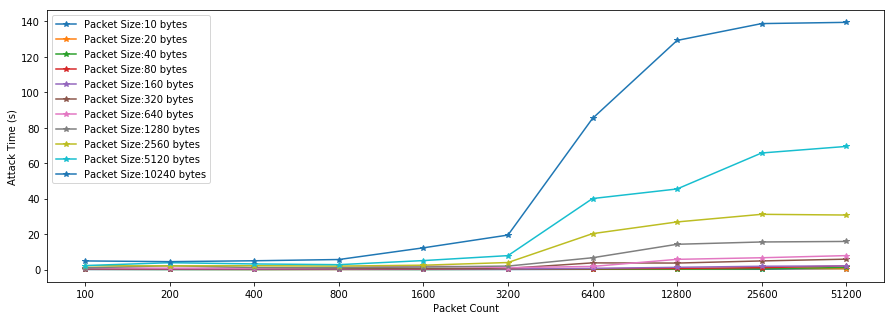

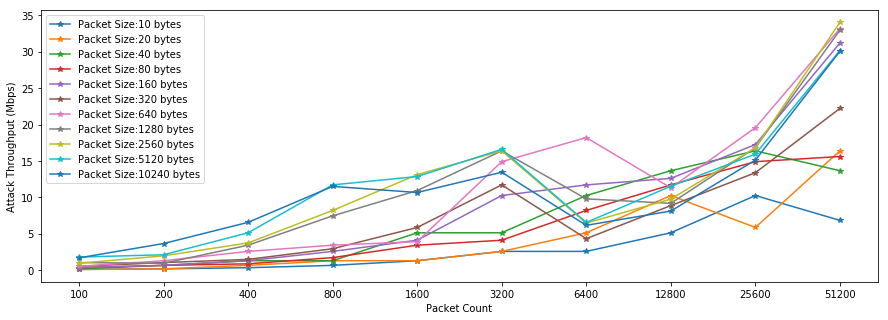

In [312]:
attack_label=np.array(pd.read_csv('../raw_data/20190227/ping_label.txt', delimiter=' ', header=None))[110:220, :]
# label: (start_time, end_time, count, size)

ts=[0]*8
for i in range(8):
    raw_data=pd.read_csv('../raw_data/20190227/ping_attack01_monitor0%d.dat' % (i+1), delimiter=',', header=None)
    ts[i]=pd.Series(list(raw_data[1]), pd.to_datetime(raw_data[0], unit='ms', utc=True).dt.tz_convert('US/Eastern'))
    
seg=[[0]*8]*110
mean_abnormal=[[0]]*110
mean_normal=[[0]]*110
var_abnormal=[[0]]*110
var_normal=[[0]]*110
seg_len=[[0]]*110
for j in range(11):
    for k in range(10):
        index=int(j*10+k)
        for i in range(8):
            mask=(ts[i].index > ('2019-02-27 '+str(attack_label[index][0])))& \
                (ts[i].index < ('2019-02-27 '+str(attack_label[index][1])))
            seg[index][i]=(ts[i][mask])
        seg_len[index]=seg[index][0].shape[0]
        mean_abnormal[index]=np.mean(seg[index][0]) # only #1 was attacked
        mean_normal[index]=np.mean(seg[index][2])
        var_abnormal[index]=np.var(seg[index][0]) # only #1 was attacked
        var_normal[index]=np.var(seg[index][4])
seg_len=np.array(seg_len).reshape(11,10)
mean_abnormal=np.array(mean_abnormal).reshape(11,10)
mean_normal=np.array(mean_normal).reshape(11,10)
var_abnormal=np.array(var_abnormal).reshape(11,10)
var_normal=np.array(var_normal).reshape(11,10)
packet_count=[10,20,40,80,160,320,640,1280,2560,5120,10240]
packet_size=[100,200,400,800,1600,3200,6400,12800,25600,51200]

# Attack Time vs Packet Count and Packet Size
plt.figure(figsize = (15, 5))
for i in range(11):
    plt.plot(seg_len[i,:]/10, '*-')
plt.xlabel('Packet Count')
plt.ylabel('Attack Time (s)')
plt.xticks(range(10), packet_size)
plt.legend([('Packet Size:' + str(i) + ' bytes') for i in packet_count])

# Attack Throughput vs Packet Count and Packet Size
plt.figure(figsize = (15, 5))
amount=np.multiply(np.array(packet_count).reshape(11,1), np.array(packet_size).reshape(1,10))
throughput=np.divide(amount, seg_len/10)*8/1000/1000
for i in range(11):
    plt.plot(throughput[i,:], '*-')
plt.xlabel('Packet Count')
plt.ylabel('Attack Throughput (Mbps)')
plt.xticks(range(10), packet_size)
plt.legend([('Packet Size:' + str(i) + ' bytes') for i in packet_count])

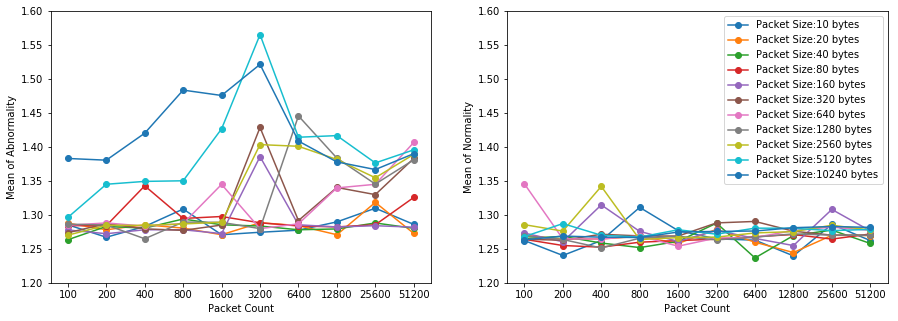

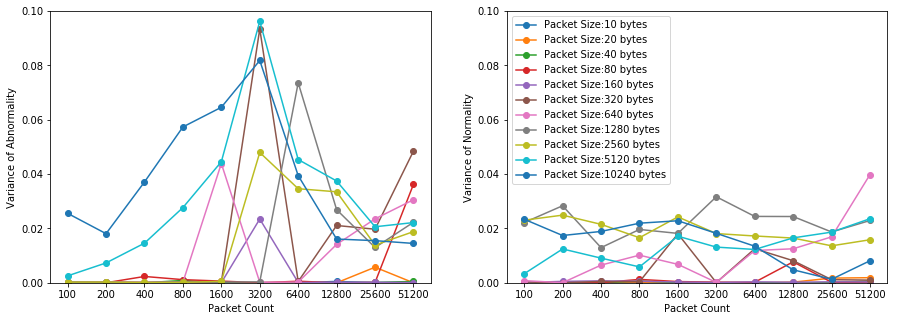

In [313]:
# Examine the Mean or Variance comparing between Abnormality and Normality vs Packet Count and Packet Size
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
for i in range(11):
    plt.plot(mean_abnormal[i,:], 'o-')
plt.xlabel('Packet Count')
plt.ylabel('Mean of Abnormality')
plt.ylim([1.2, 1.6])
plt.xticks(range(10), packet_size)
#plt.legend([('Packet Size:' + str(i)) for i in packet_count])

plt.subplot(1,2,2)
for i in range(11):
    plt.plot(mean_normal[i,:], 'o-')
plt.xlabel('Packet Count')
plt.ylabel('Mean of Normality')
plt.ylim([1.2, 1.6])
plt.xticks(range(10), packet_size)
plt.legend([('Packet Size:' + str(i) + ' bytes') for i in packet_count])

plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
for i in range(11):
    plt.plot(var_abnormal[i,:], 'o-')
plt.xlabel('Packet Count')
plt.ylabel('Variance of Abnormality')
plt.ylim([0, 0.1])
plt.xticks(range(10), packet_size)
#plt.legend([('Packet Size:' + str(i)) for i in packet_count])

plt.subplot(1,2,2)
for i in range(11):
    plt.plot(var_normal[i,:], 'o-')
plt.xlabel('Packet Count')
plt.ylabel('Variance of Normality')
plt.ylim([0, 0.1])
plt.xticks(range(10), packet_size)
plt.legend([('Packet Size:' + str(i) + ' bytes') for i in packet_count])

In [701]:
# clips only containing data under attack
attack_label=np.array(pd.read_csv('../raw_data/20190227/ping_label.txt', delimiter=' ', header=None))[110:220, :]
# label: (start_time, end_time, count, size)

attack_arr = read_channels('../raw_data/20190227/ping_attack01_monitor', plot=False)
eig_attack = []
for j in range(11):
    for k in range(10):
        index=int(j*10+k)
        attack_clip = clip_channels(attack_arr, startTime='2019-02-27 '+str(attack_label[index][0]), 
                                 endTime='2019-02-27 '+str(attack_label[index][1]))
        attack_matrix = stack_channels(attack_clip)

        len_size=10*60
        if attack_matrix.shape[0] >= len_size:
            length = len(attack_clip[0])
            for i in range(0, length-len_size, 10):
                eig_arr = pca_eigenvalues(attack_matrix[(i):(i+len_size-1),])[0]
                eig_attack.append(eig_arr)
            
print(len(eig_attack))

271


In [5]:
# clips containing parts without attack
attack_label=np.array(pd.read_csv('../raw_data/20190227/ping_label.txt', delimiter=' ', header=None))[110:220, :]
# label: (start_time, end_time, count, size)

attack_arr = read_channels('../raw_data/20190227/ping_attack01_monitor', plot=False)
eig_attack = []

attack_clip = clip_channels(attack_arr, startTime='2019-02-27 16:43:00', 
                endTime='2019-02-27 17:09:48', plot=False, ylim=[1.0,2.5])
attack_matrix = stack_channels(attack_clip)

len_size=10*40
length = len(attack_clip[0])
for i in range(0, length-len_size, 10):
    eig_arr = pca_eigenvalues(attack_matrix[(i):(i+len_size-1),])[0]
    eig_attack.append(eig_arr)
            
print(len(eig_attack))

1568


In [6]:
arr = read_channels('../raw_data/20190228/clean_10h_monitor', plot=False)
arr_clip = clip_channels(arr, startTime='2019-02-28 11:30:00', endTime='2019-02-28 11:57:00', plot=False, ylim=[1.0,2.5])
arr_matrix = stack_channels(arr_clip)
eig=[]
win_size=10*40
len_size=10*60*27
for i in range(0,len_size-win_size,10):
    eig_arr = pca_eigenvalues(arr_matrix[(i):(i+win_size-1),])[0]
    eig.append(eig_arr)
print(len(eig))

1580


In [7]:
samples_abnormal = [(i, 1) for i in eig_attack]
samples_normal = [(i, 0) for i in eig]
samples = samples_abnormal + samples_normal
np.random.shuffle(samples)
training_samples=samples[:int(len(samples)*0.7)]
testing_samples=samples[int(len(samples)*0.7):]
training_X=[i[0] for i in training_samples]
training_y=[i[1] for i in training_samples]
testing_X=[i[0] for i in testing_samples]
testing_y=[i[1] for i in testing_samples]

In [114]:
from sklearn.linear_model import LogisticRegressionCV

log_reg = LogisticRegressionCV(solver='liblinear', cv=10, max_iter=1000)
log_reg.fit(training_X, training_y)
log_reg.score(testing_X, testing_y)
# log_reg.predict(eig_attack)

0.8380952380952381

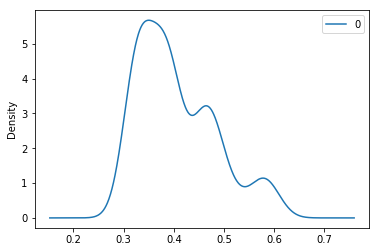

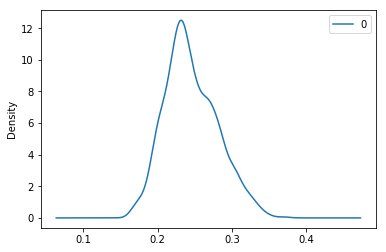

In [561]:
eig_1=[i[0] for i in eig_attack]
df=pd.DataFrame(eig_1)
df.plot.kde()
eig_2=[i[0] for i in eig]
df=pd.DataFrame(eig_2)
df.plot.kde()

In [ ]:
# from scipy.signal import find_peaks

arr_find_peaks = arr_matrix
peaks, _ = find_peaks(arr_find_peaks[:,1], height=1.4)
plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
plt.plot(arr_matrix[:,1])
plt.ylim([1.0, 3.0])
plt.plot(peaks, arr_matrix[:,1][peaks], "x")
for i in range(len(peaks)):
    arr_find_peaks[:,1][peaks[i]] = (arr_find_peaks[:,1][peaks[i]-1] + arr_find_peaks[:,1][peaks[i]+1]) * 0.5
plt.subplot(2,1,2)
plt.plot(arr_find_peaks[:,1])
plt.ylim([1.0, 3.0])

595


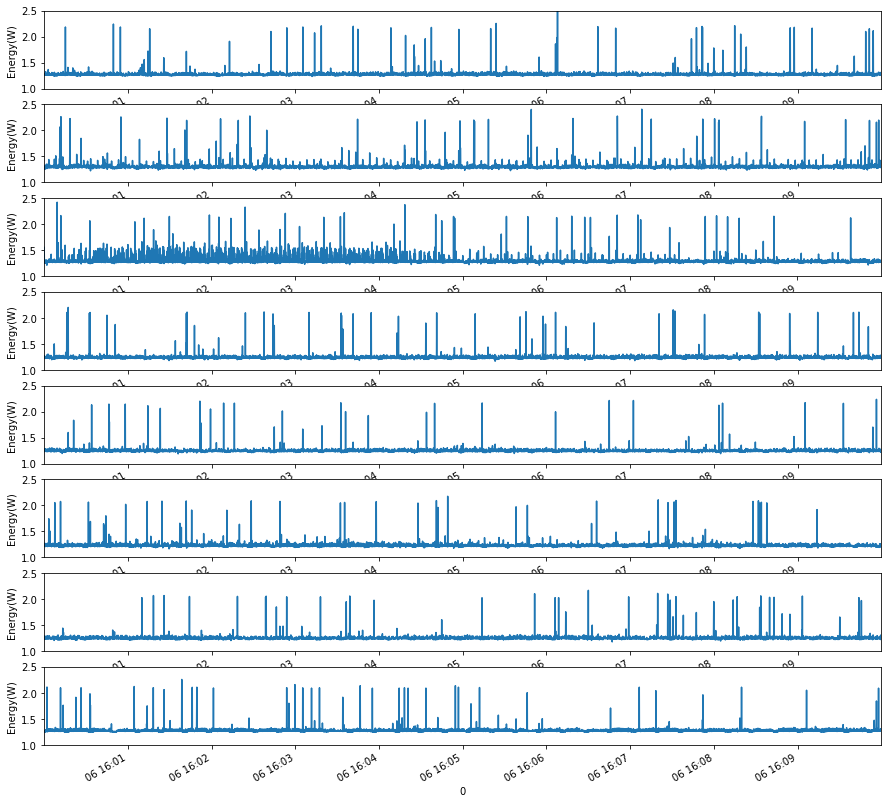

In [809]:
arr = read_channels('../raw_data/20190307/2d_monitor', plot=False)
arr_clip = clip_channels(arr, startTime='2019-03-06 16:00:00', endTime='2019-03-06 16:10:00', plot=True, ylim=[1.0,2.5])
arr_matrix = stack_channels(arr_clip)
test_eig = []
win_size = 10*5
len_size = 10*60*10
for i in range(0,len_size-win_size,10):
    eig_arr = pca_eigenvalues(arr_matrix[(i):(i+win_size-1),])[0]
    test_eig.append(eig_arr)
print(len(test_eig))

In [885]:
import subprocess
import time

while True:
    subprocess.call(['./real_time_recv.sh'])
    arr = read_channels('../raw_data/realtime/latest_monitor', plot=False, ylim=[1.0,2.5])
    arr_matrix = stack_channels(arr)
    test_eig = [pca_eigenvalues(arr_matrix)[0]]

    log_result=log_reg.predict(test_eig)
    log_prob=log_reg.predict_proba(test_eig)
    # print(log_result, log_prob)
    subprocess.call(['./real_time_send.sh', str(int(log_result)), str(log_prob[0,0]), str(log_prob[0,1])])
    time.sleep(1)

[0] [[0.602 0.398]]
[0] [[0.734 0.266]]
[0] [[0.734 0.266]]
[0] [[0.734 0.266]]
[0] [[0.734 0.266]]
[0] [[0.734 0.266]]
[0] [[0.832 0.168]]
[0] [[0.728 0.272]]
[0] [[0.617 0.383]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.667 0.333]]
[0] [[0.786 0.214]]
[0] [[0.767 0.233]]
[0] [[0.581 0.419]]
[0] [[0.581 0.419]]
[0] [[0.581 0.419]]
[0] [[0.581 0.419]]
[0] [[0.581 0.419]]
[0] [[0.586 0.414]]
[0] [[0.662 0.338]]
[0] [[0.663 0.337]]
[0] [[0.655 0.345]]
[0] [[0.655 0.345]]
[0] [[0.655 0.345]]
[0] [[0.655 0.345]]
[0] [[0.653 0.347]]
[0] [[0.836 0.164]]
[0] [[0.835 0.165]]
[0] [[0.807 0.193]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.777 0.223]]
[0] [[0.522 0.478]]
[1] [[0.499 0.501]]
[0] [[0.701 0.299]]
[0] [[0.701 0.299]]
[0] [[0.701 0.299]]
[0] [[0.701 0.299]]
[0] [[0.701 0.299]]
[0] [[0.762 0.238]]
[0] [[0.765 0.235]]
[0] [[0.793 0.207]]
[0] [[0.721 0.279]]
[0] [[0.721 0.279]]


[0] [[0.688 0.312]]
[0] [[0.567 0.433]]
[0] [[0.567 0.433]]
[0] [[0.567 0.433]]
[0] [[0.567 0.433]]
[0] [[0.567 0.433]]
[0] [[0.79 0.21]]
[0] [[0.86 0.14]]
[1] [[0.446 0.554]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.367 0.633]]
[1] [[0.36 0.64]]
[1] [[0.099 0.901]]
[1] [[0.062 0.938]]
[1] [[0.062 0.938]]
[1] [[0.062 0.938]]
[1] [[0.062 0.938]]
[1] [[0.062 0.938]]
[1] [[0.065 0.935]]
[1] [[0.085 0.915]]
[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.045 0.955]]
[1] [[0.115 0.885]]
[1] [[0.114 0.886]]
[1] [[0.16 0.84]]
[1] [[0.16 0.84]]
[1] [[0.16 0.84]]
[1] [[0.16 0.84]]
[1] [[0.097 0.903]]
[1] [[0.07 0.93]]
[1] [[0.051 0.949]]
[1] [[0.114 0.886]]
[1] [[0.114 0.886]]
[1] [[0.114 0.886]]
[1] [[0.114 0.886]]
[1] [[0.114 0.886]]
[1] [[0.067 0.933]]
[1] [[0.072 0.928]]
[1] [[0.119 0.881]]
[1] [[0.251 0.749]]
[1] [[0.258 0.742]]
[1] [[0.258 0.74

[1] [[0.005 0.995]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.004 0.996]]
[1] [[0.004 0.996]]
[1] [[0.004 0.996]]
[1] [[0.004 0.996]]
[1] [[0.004 0.996]]
[1] [[0.004 0.996]]
[1] [[0.002 0.998]]
[1] [[0.002 0.998]]
[1] [[0.002 0.998]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.003 0.997]]
[1] [[0.009 0.991]]
[1] [[0.035 0.965]]
[1] [[0.036 0.964]]
[1] [[0.051 0.949]]
[1] [[0.051 0.949]]
[1] [[0.051 0.949]]
[1] [[0.051 0.949]]
[1] [[0.051 0.949]]
[1] [[0.058 0.942]]
[1] [[0.085 0.915]]
[1] [[0.066 0.934]]
[1] [[0.065 0.935]]
[1] [[0.065 0.935]]
[1] [[0.065 0.935]]
[1] [[0.065 0.935]]
[1] [[0.065 0.935]]
[1] [[0.098 0.902]]
[1] [[0.099 0.901]]
[1] [[0.024 0.976]]
[1] [[0.03 0.97]]
[1] [[0.03 0.97]]
[1] [[0.03 0.97]]
[1] [[0.03 0.97]]
[1] [[0.03 0.97]]
[1] [[0.03 0.97]]
[1] [[0.031 0.969]]
[1] [[0.043 0.957]]
[1] [[0.041 0.959]]
[1] [[0.041 

[0] [[0.87 0.13]]
[0] [[0.87 0.13]]
[0] [[0.892 0.108]]
[0] [[0.863 0.137]]
[0] [[0.844 0.156]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.895 0.105]]
[0] [[0.92 0.08]]
[0] [[0.925 0.075]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.74 0.26]]
[0] [[0.725 0.275]]
[0] [[0.735 0.265]]
[0] [[0.735 0.265]]
[0] [[0.735 0.265]]
[0] [[0.735 0.265]]
[0] [[0.733 0.267]]
[0] [[0.824 0.176]]
[0] [[0.826 0.174]]
[0] [[0.675 0.325]]
[0] [[0.678 0.322]]
[0] [[0.678 0.322]]
[0] [[0.678 0.322]]
[0] [[0.678 0.322]]
[0] [[0.677 0.323]]
[0] [[0.658 0.342]]
[0] [[0.674 0.326]]
[0] [[0.805 0.195]]
[0] [[0.805 0.195]]
[0] [[0.805 0.195]]
[0] [[0.805 0.195]]
[0] [[0.805 0.195]]
[0] [[0.805 0.195]]
[0] [[0.856 0.144]]
[0] [[0.821 0.179]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.

[0] [[0.886 0.114]]
[0] [[0.886 0.114]]
[0] [[0.886 0.114]]
[0] [[0.865 0.135]]
[0] [[0.88 0.12]]
[0] [[0.914 0.086]]
[0] [[0.848 0.152]]
[0] [[0.848 0.152]]
[0] [[0.848 0.152]]
[0] [[0.848 0.152]]
[0] [[0.848 0.152]]
[0] [[0.897 0.103]]
[0] [[0.831 0.169]]
[0] [[0.83 0.17]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.888 0.112]]
[0] [[0.846 0.154]]
[0] [[0.843 0.157]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.865 0.135]]
[0] [[0.877 0.123]]
[0] [[0.766 0.234]]
[0] [[0.842 0.158]]
[0] [[0.842 0.158]]
[0] [[0.842 0.158]]
[0] [[0.842 0.158]]
[0] [[0.842 0.158]]
[0] [[0.696 0.304]]
[0] [[0.693 0.307]]
[0] [[0.849 0.151]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.818 0.182]]
[0] [[0.859 0.141]]
[0] [[0.858 0.142]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.823 0.

[0] [[0.674 0.326]]
[0] [[0.707 0.293]]
[0] [[0.707 0.293]]
[0] [[0.707 0.293]]
[0] [[0.707 0.293]]
[0] [[0.706 0.294]]
[0] [[0.748 0.252]]
[0] [[0.784 0.216]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.863 0.137]]
[0] [[0.883 0.117]]
[0] [[0.874 0.126]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.915 0.085]]
[0] [[0.931 0.069]]
[0] [[0.857 0.143]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.873 0.127]]
[0] [[0.839 0.161]]
[0] [[0.77 0.23]]
[0] [[0.767 0.233]]
[0] [[0.767 0.233]]
[0] [[0.767 0.233]]
[0] [[0.767 0.233]]
[0] [[0.767 0.233]]
[0] [[0.649 0.351]]
[0] [[0.733 0.267]]
[0] [[0.626 0.374]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.714 0.286]]
[0] [[0.917 0.083]]
[0] [[0.928 0.072]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 

[0] [[0.889 0.111]]
[0] [[0.886 0.114]]
[0] [[0.846 0.154]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.774 0.226]]
[0] [[0.776 0.224]]
[0] [[0.78 0.22]]
[1] [[0.465 0.535]]
[1] [[0.465 0.535]]
[1] [[0.465 0.535]]
[1] [[0.465 0.535]]
[1] [[0.465 0.535]]
[1] [[0.45 0.55]]
[0] [[0.556 0.444]]
[0] [[0.548 0.452]]
[0] [[0.669 0.331]]
[0] [[0.669 0.331]]
[0] [[0.669 0.331]]
[0] [[0.669 0.331]]
[0] [[0.669 0.331]]
[0] [[0.773 0.227]]
[0] [[0.76 0.24]]
[0] [[0.841 0.159]]
[0] [[0.875 0.125]]
[0] [[0.875 0.125]]
[0] [[0.875 0.125]]
[0] [[0.875 0.125]]
[0] [[0.875 0.125]]
[0] [[0.879 0.121]]
[0] [[0.819 0.181]]
[0] [[0.854 0.146]]
[0] [[0.859 0.141]]
[0] [[0.859 0.141]]
[0] [[0.859 0.141]]
[0] [[0.859 0.141]]
[0] [[0.815 0.185]]
[0] [[0.831 0.169]]
[0] [[0.886 0.114]]
[0] [[0.786 0.214]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.786 0.214]]
[0] [[0.718 0.282]]
[0] [[0.713 0.287]]
[0] [[

[0] [[0.587 0.413]]
[0] [[0.583 0.417]]
[0] [[0.638 0.362]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.779 0.221]]
[0] [[0.726 0.274]]
[0] [[0.723 0.277]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.69 0.31]]
[0] [[0.869 0.131]]
[0] [[0.836 0.164]]
[0] [[0.836 0.164]]
[0] [[0.836 0.164]]
[0] [[0.836 0.164]]
[0] [[0.836 0.164]]
[0] [[0.836 0.164]]
[0] [[0.824 0.176]]
[0] [[0.825 0.175]]
[0] [[0.833 0.167]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.865 0.135]]
[0] [[0.766 0.234]]
[1] [[0.217 0.783]]
[1] [[0.218 0.782]]
[1] [[0.218 0.782]]
[1] [[0.218 0.782]]
[1] [[0.218 0.782]]
[1] [[0.218 0.782]]
[1] [[0.253 0.747]]
[1] [[0.191 0.809]]
[1] [[0.103 0.897]]
[1] [[0.111 0.889]]
[1] [[0.111 0.889]]
[1] [[0.111 0.889]]
[1] [[0.111 0.889]]
[1] [[0.111 0.889]]
[1] [[0.111 0.889]]
[1] [[0.085 0.915]]
[1

[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.938 0.062]]
[0] [[0.897 0.103]]
[0] [[0.835 0.165]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.918 0.082]]
[0] [[0.949 0.051]]
[0] [[0.899 0.101]]
[0] [[0.941 0.059]]
[0] [[0.941 0.059]]
[0] [[0.941 0.059]]
[0] [[0.941 0.059]]
[0] [[0.929 0.071]]
[0] [[0.936 0.064]]
[0] [[0.915 0.085]]
[0] [[0.907 0.093]]
[0] [[0.907 0.093]]
[0] [[0.907 0.093]]
[0] [[0.907 0.093]]
[0] [[0.907 0.093]]
[0] [[0.893 0.107]]
[0] [[0.709 0.291]]
[0] [[0.79 0.21]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.717 0.283]]
[0] [[0.703 0.297]]
[0] [[0.868 0.132]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.906 0.094]]
[0] [[0.84 0.16]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.933 0.067]]
[0] [[0.836 0.

[1] [[0.488 0.512]]
[1] [[0.488 0.512]]
[1] [[0.488 0.512]]
[1] [[0.488 0.512]]
[0] [[0.548 0.452]]
[0] [[0.838 0.162]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.874 0.126]]
[0] [[0.969 0.031]]
[0] [[0.893 0.107]]
[0] [[0.887 0.113]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.912 0.088]]
[0] [[0.926 0.074]]
[0] [[0.906 0.094]]
[0] [[0.882 0.118]]
[0] [[0.871 0.129]]
[0] [[0.871 0.129]]
[0] [[0.871 0.129]]
[0] [[0.871 0.129]]
[0] [[0.852 0.148]]
[0] [[0.805 0.195]]
[0] [[0.761 0.239]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.75 0.25]]
[0] [[0.81 0.19]]
[0] [[0.75 0.25]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.659 0.341]]
[0] [[0.638 0.362]]
[0] [[0.859 0.141]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.

[1] [[0.388 0.612]]
[1] [[0.388 0.612]]
[1] [[0.388 0.612]]
[1] [[0.403 0.597]]
[0] [[0.602 0.398]]
[0] [[0.716 0.284]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.748 0.252]]
[0] [[0.685 0.315]]
[0] [[0.729 0.271]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.875 0.125]]
[0] [[0.926 0.074]]
[0] [[0.937 0.063]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.936 0.064]]
[0] [[0.896 0.104]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.868 0.132]]
[0] [[0.855 0.145]]
[0] [[0.87 0.13]]
[0] [[0.923 0.077]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.917 0.083]]
[0] [[0.935 0.065]]
[0] [[0.915 0.085]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0

[0] [[0.887 0.113]]
[0] [[0.936 0.064]]
[0] [[0.948 0.052]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.944 0.056]]
[0] [[0.942 0.058]]
[0] [[0.925 0.075]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.913 0.087]]
[0] [[0.892 0.108]]
[0] [[0.883 0.117]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.887 0.113]]
[0] [[0.832 0.168]]
[0] [[0.79 0.21]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.852 0.148]]
[0] [[0.843 0.157]]
[0] [[0.873 0.127]]
[0] [[0.835 0.165]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.818 0.182]]
[0] [[0.815 0.185]]
[0] [[0.893 0.107]]
[0] [[0.799 0.201]]
[0] [[0.799 0.201]]
[0] [[0.799 0.201]]
[0] [[0.799 0.201]]
[0] [[0.799 0.201]]
[0] [[0.667 0.333]]
[0] [[0.73 0.27]]
[0] [[0.875 0.125]]
[0] 

[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.876 0.124]]
[0] [[0.812 0.188]]
[0] [[0.71 0.29]]
[0] [[0.71 0.29]]
[0] [[0.71 0.29]]
[0] [[0.71 0.29]]
[0] [[0.71 0.29]]
[1] [[0.311 0.689]]
[1] [[0.255 0.745]]
[1] [[0.27 0.73]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.268 0.732]]
[1] [[0.199 0.801]]
[1] [[0.174 0.826]]
[1] [[0.386 0.614]]
[1] [[0.381 0.619]]
[1] [[0.381 0.619]]
[1] [[0.381 0.619]]
[1] [[0.381 0.619]]
[1] [[0.381 0.619]]
[1] [[0.258 0.742]]
[1] [[0.289 0.711]]
[1] [[0.315 0.685]]
[1] [[0.342 0.658]]
[1] [[0.342 0.658]]
[1] [[0.342 0.658]]
[1] [[0.342 0.658]]
[1] [[0.342 0.658]]
[1] [[0.378 0.622]]
[1] [[0.388 0.612]]
[1] [[0.377 0.623]]
[1] [[0.375 0.625]]
[1] [[0.375 0.625]]
[1] [[0.375 0.625]]
[1] [[0.375 0.625]]
[0] [[0.509 0.491]]
[0] [[0.601 0.399]]
[0] [[0.561 0.439]]
[0] [[0.621 0.379]]
[0] [[0.698 0.302]]
[0] [[0.698 0.302]]
[0] [[0.698 0.302]]
[0] [[0.698 0.302]]
[0] [[0.622 0.378]]


[0] [[0.776 0.224]]
[0] [[0.776 0.224]]
[0] [[0.839 0.161]]
[0] [[0.824 0.176]]
[0] [[0.815 0.185]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.827 0.173]]
[0] [[0.835 0.165]]
[0] [[0.84 0.16]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.769 0.231]]
[0] [[0.86 0.14]]
[0] [[0.84 0.16]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.87 0.13]]
[0] [[0.896 0.104]]
[0] [[0.852 0.148]]
[0] [[0.86 0.14]]
[0] [[0.86 0.14]]
[0] [[0.86 0.14]]
[0] [[0.86 0.14]]
[0] [[0.86 0.14]]
[0] [[0.863 0.137]]
[0] [[0.858 0.142]]
[0] [[0.814 0.186]]
[0] [[0.862 0.138]]
[0] [[0.862 0.138]]
[0] [[0.862 0.138]]
[0] [[0.862 0.138]]
[0] [[0.862 0.138]]
[0] [[0.831 0.169]]
[0] [[0.768 0.232]]
[0] [[0.583 0.417]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.767 0.233]]
[0] [[0.775 0.225]

[0] [[0.94 0.06]]
[0] [[0.945 0.055]]
[0] [[0.939 0.061]]
[0] [[0.908 0.092]]
[0] [[0.909 0.091]]
[0] [[0.908 0.092]]
[0] [[0.908 0.092]]
[0] [[0.908 0.092]]
[0] [[0.908 0.092]]
[0] [[0.91 0.09]]
[0] [[0.908 0.092]]
[0] [[0.873 0.127]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.915 0.085]]
[0] [[0.886 0.114]]
[0] [[0.927 0.073]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.916 0.084]]
[0] [[0.952 0.048]]
[0] [[0.942 0.058]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.92 0.08]]
[0] [[0.955 0.045]]
[0] [[0.94 0.06]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.929 0.071]]
[0] [[0.936 0.064]]
[0] [[0.948 0.052]]
[0] [[0.965 0.035]]
[0] [[0.965 0.035]]
[0] [[0.965 0.035]]
[0] [[0.965 0.035]]
[0] [[0.961 0.039]]
[0] [[0.942 0.058]]
[0] [[0.

[0] [[0.834 0.166]]
[0] [[0.862 0.138]]
[0] [[0.508 0.492]]
[0] [[0.524 0.476]]
[0] [[0.739 0.261]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.826 0.174]]
[0] [[0.881 0.119]]
[0] [[0.891 0.109]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.89 0.11]]
[0] [[0.889 0.111]]
[0] [[0.886 0.114]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.859 0.141]]
[0] [[0.878 0.122]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.848 0.152]]
[0] [[0.8 0.2]]
[0] [[0.586 0.414]]
[0] [[0.673 0.327]]
[0] [[0.673 0.327]]
[0] [[0.673 0.327]]
[0] [[0.673 0.327]]
[0] [[0.673 0.327]]
[0] [[0.728 0.272]]
[1] [[0.44 0.56]]
[0] [[0.609 0.391]]
[0] [[0.601 0.399]]
[0] [[0.601 0.399]]
[0] [[0.601 0.399]]
[0] [[0.601 0.399]]
[0] [[0.601 0.399]]
[0] [[0.791 0.209]]
[0] [[0.

[0] [[0.607 0.393]]
[0] [[0.607 0.393]]
[0] [[0.708 0.292]]
[0] [[0.709 0.291]]
[0] [[0.594 0.406]]
[0] [[0.678 0.322]]
[0] [[0.678 0.322]]
[0] [[0.678 0.322]]
[0] [[0.678 0.322]]
[0] [[0.678 0.322]]
[0] [[0.758 0.242]]
[0] [[0.866 0.134]]
[0] [[0.887 0.113]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.908 0.092]]
[0] [[0.889 0.111]]
[0] [[0.919 0.081]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.937 0.063]]
[0] [[0.921 0.079]]
[0] [[0.959 0.041]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.92 0.08]]
[0] [[0.901 0.099]]
[0] [[0.905 0.095]]
[0] [[0.911 0.089]]
[0] [[0.911 0.089]]
[0] [[0.911 0.089]]
[0] [[0.911 0.089]]
[0] [[0.887 0.113]]
[0] [[0.836 0.164]]
[0] [[0.792 0.208]]
[0] [[0.549 0.451]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.746 0.254]]
[0

[1] [[0.222 0.778]]
[1] [[0.224 0.776]]
[1] [[0.224 0.776]]
[1] [[0.224 0.776]]
[1] [[0.224 0.776]]
[1] [[0.224 0.776]]
[1] [[0.35 0.65]]
[0] [[0.855 0.145]]
[0] [[0.878 0.122]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.882 0.118]]
[0] [[0.753 0.247]]
[0] [[0.75 0.25]]
[0] [[0.759 0.241]]
[0] [[0.759 0.241]]
[0] [[0.759 0.241]]
[0] [[0.759 0.241]]
[0] [[0.759 0.241]]
[0] [[0.769 0.231]]
[0] [[0.889 0.111]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.934 0.066]]
[0] [[0.935 0.065]]
[0] [[0.912 0.088]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.885 0.115]]
[0] [[0.584 0.416]]
[0] [[0.685 0.315]]
[0] [[0.641 0.359]]
[0] [[0.648 0.352]]
[0] [[0.648 0.352]]
[0] [[0.648 0.352]]
[0] [[0.648 0.352]]
[0] [[0.692 0.308]]
[0] [[0.839 0.161]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.

[0] [[0.831 0.169]]
[0] [[0.791 0.209]]
[0] [[0.889 0.111]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.721 0.279]]
[1] [[0.13 0.87]]
[1] [[0.136 0.864]]
[1] [[0.271 0.729]]
[1] [[0.271 0.729]]
[1] [[0.271 0.729]]
[1] [[0.271 0.729]]
[1] [[0.271 0.729]]
[1] [[0.264 0.736]]
[1] [[0.396 0.604]]
[0] [[0.7 0.3]]
[0] [[0.704 0.296]]
[0] [[0.704 0.296]]
[0] [[0.704 0.296]]
[0] [[0.704 0.296]]
[0] [[0.704 0.296]]
[0] [[0.779 0.221]]
[0] [[0.848 0.152]]
[0] [[0.832 0.168]]
[0] [[0.831 0.169]]
[0] [[0.831 0.169]]
[0] [[0.831 0.169]]
[0] [[0.831 0.169]]
[0] [[0.831 0.169]]
[0] [[0.904 0.096]]
[0] [[0.923 0.077]]
[0] [[0.913 0.087]]
[0] [[0.911 0.089]]
[0] [[0.911 0.089]]
[0] [[0.911 0.089]]
[0] [[0.911 0.089]]
[0] [[0.924 0.076]]
[0] [[0.929 0.071]]
[0] [[0.955 0.045]]
[0] [[0.89 0.11]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.821 0.179]]
[0] [[0.834 0.166]]
[0] [[0.837 0.163]]
[0] [[0.833 0.16

[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.927 0.073]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.834 0.166]]
[0] [[0.834 0.166]]
[0] [[0.812 0.188]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.914 0.086]]
[0] [[0.909 0.091]]
[0] [[0.66 0.34]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.737 0.263]]
[0] [[0.708 0.292]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.815 0.185]]
[0] [[0.811 0.189]]
[0] [[0.745 0.255]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.827 0.173]]
[0] [[0.919 0.081]]
[0] [[0.933 0.067]]
[0] [[0.93 0.07]]
[0] [[0.93 0.07]]
[0] [[0.93 0.07]]
[0] [[0.93 0.07]]
[0] [[0.872 0.128]]
[0] [[0.815 0.185]]
[0] [[0.826 0.174]]


[1] [[0.416 0.584]]
[1] [[0.416 0.584]]
[1] [[0.416 0.584]]
[1] [[0.416 0.584]]
[1] [[0.439 0.561]]
[1] [[0.385 0.615]]
[0] [[0.583 0.417]]
[0] [[0.738 0.262]]
[0] [[0.738 0.262]]
[0] [[0.738 0.262]]
[0] [[0.738 0.262]]
[0] [[0.738 0.262]]
[0] [[0.851 0.149]]
[0] [[0.905 0.095]]
[0] [[0.814 0.186]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.927 0.073]]
[0] [[0.948 0.052]]
[0] [[0.891 0.109]]
[0] [[0.955 0.045]]
[0] [[0.955 0.045]]
[0] [[0.955 0.045]]
[0] [[0.955 0.045]]
[0] [[0.955 0.045]]
[0] [[0.957 0.043]]
[0] [[0.938 0.062]]
[0] [[0.731 0.269]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.747 0.253]]
[0] [[0.824 0.176]]
[0] [[0.822 0.178]]
[0] [[0.764 0.236]]
[0] [[0.75 0.25]]
[0] [[0.75 0.25]]
[0] [[0.75 0.25]]
[0] [[0.75 0.25]]
[0] [[0.75 0.25]]
[0] [[0.648 0.352]]
[0] [[0.876 0.124]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.89

[0] [[0.848 0.152]]
[0] [[0.923 0.077]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.921 0.079]]
[0] [[0.884 0.116]]
[0] [[0.907 0.093]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.914 0.086]]
[0] [[0.815 0.185]]
[0] [[0.858 0.142]]
[0] [[0.709 0.291]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.836 0.164]]
[0] [[0.82 0.18]]
[0] [[0.8 0.2]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.936 0.064]]
[0] [[0.918 0.082]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.865 0.135]]
[0] [[0.856 0.144]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.829 0.171]]
[0] [[0.58 0.42]]
[0] [[0.581 0.419]]
[1] [[0.

[1] [[0.203 0.797]]
[1] [[0.203 0.797]]
[1] [[0.203 0.797]]
[1] [[0.203 0.797]]
[1] [[0.229 0.771]]
[1] [[0.161 0.839]]
[1] [[0.099 0.901]]
[1] [[0.125 0.875]]
[1] [[0.125 0.875]]
[1] [[0.125 0.875]]
[1] [[0.125 0.875]]
[1] [[0.125 0.875]]
[1] [[0.129 0.871]]
[1] [[0.116 0.884]]
[1] [[0.159 0.841]]
[1] [[0.159 0.841]]
[1] [[0.159 0.841]]
[1] [[0.159 0.841]]
[1] [[0.159 0.841]]
[1] [[0.159 0.841]]
[1] [[0.137 0.863]]
[1] [[0.14 0.86]]
[1] [[0.141 0.859]]
[1] [[0.131 0.869]]
[1] [[0.131 0.869]]
[1] [[0.131 0.869]]
[1] [[0.131 0.869]]
[1] [[0.176 0.824]]
[1] [[0.096 0.904]]
[1] [[0.07 0.93]]
[1] [[0.086 0.914]]
[1] [[0.086 0.914]]
[1] [[0.086 0.914]]
[1] [[0.086 0.914]]
[1] [[0.086 0.914]]
[1] [[0.087 0.913]]
[1] [[0.154 0.846]]
[1] [[0.206 0.794]]
[1] [[0.262 0.738]]
[1] [[0.251 0.749]]
[1] [[0.251 0.749]]
[1] [[0.251 0.749]]
[1] [[0.251 0.749]]
[1] [[0.255 0.745]]
[1] [[0.256 0.744]]
[1] [[0.254 0.746]]
[1] [[0.199 0.801]]
[1] [[0.209 0.791]]
[1] [[0.209 0.791]]
[1] [[0.209 0.791]]
[1] 

[0] [[0.72 0.28]]
[0] [[0.702 0.298]]
[0] [[0.732 0.268]]
[0] [[0.711 0.289]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.634 0.366]]
[0] [[0.715 0.285]]
[0] [[0.702 0.298]]
[0] [[0.707 0.293]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[0.682 0.318]]
[0] [[0.663 0.337]]
[0] [[0.668 0.332]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.723 0.277]]
[0] [[0.672 0.328]]
[0] [[0.51 0.49]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.788 0.212]]
[0] [[0.783 0.217]]
[0] [[0.792 0.208]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.772 0.228]]
[0] [[0.746 0.254]]
[0] [[0.748 0.252]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.863 0.137]]
[0] [[0.821 0.179]]
[0] [[0.859 0.141]]
[0] [[0.73

[0] [[0.95 0.05]]
[0] [[0.96 0.04]]
[0] [[0.96 0.04]]
[0] [[0.96 0.04]]
[0] [[0.96 0.04]]
[0] [[0.943 0.057]]
[0] [[0.926 0.074]]
[0] [[0.931 0.069]]
[0] [[0.916 0.084]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.879 0.121]]
[0] [[0.884 0.116]]
[0] [[0.891 0.109]]
[0] [[0.848 0.152]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.819 0.181]]
[0] [[0.742 0.258]]
[0] [[0.517 0.483]]
[1] [[0.493 0.507]]
[1] [[0.493 0.507]]
[1] [[0.493 0.507]]
[1] [[0.493 0.507]]
[1] [[0.493 0.507]]
[1] [[0.49 0.51]]
[0] [[0.518 0.482]]
[0] [[0.637 0.363]]
[1] [[0.265 0.735]]
[1] [[0.265 0.735]]
[1] [[0.265 0.735]]
[1] [[0.265 0.735]]
[1] [[0.265 0.735]]
[1] [[0.352 0.648]]
[1] [[0.324 0.676]]
[1] [[0.252 0.748]]
[1] [[0.294 0.706]]
[1] [[0.294 0.706]]
[1] [[0.294 0.706]]
[1] [[0.294 0.706]]
[1] [[0.294 0.706]]
[1] [[0.345 0.655]]
[1] [[0.382 0.618]]
[1] [[0.334 0.666]]
[0] [[0.542 0.458]]
[0] [[0.542 0.458]]
[0] [[0.542 0.458]]


[0] [[0.91 0.09]]
[0] [[0.91 0.09]]
[0] [[0.91 0.09]]
[0] [[0.93 0.07]]
[0] [[0.936 0.064]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.742 0.258]]
[0] [[0.738 0.262]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.759 0.241]]
[0] [[0.587 0.413]]
[0] [[0.591 0.409]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]
[0] [[0.791 0.209]]
[0] [[0.651 0.349]]
[0] [[0.745 0.255]]
[0] [[0.783 0.217]]
[0] [[0.783 0.217]]
[0] [[0.783 0.217]]
[0] [[0.783 0.217]]
[0] [[0.783 0.217]]
[0] [[0.741 0.259]]
[0] [[0.563 0.437]]
[0] [[0.691 0.309]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.854 0.146]]
[0] [[0.698 0.302]]
[0] [[0.665 0.335]]
[0] [[0.605 0.395]]
[0] [[0.605 0.395]]
[0] [[0.605 0.395]]
[0] [[0.605 0.395]]
[0] [[0.605 0.395]]
[0] [[0.826 0.174]]
[0] [[0.811 0.189]]
[0] [[0.

[0] [[0.812 0.188]]
[0] [[0.812 0.188]]
[0] [[0.812 0.188]]
[0] [[0.812 0.188]]
[0] [[0.717 0.283]]
[0] [[0.629 0.371]]
[1] [[0.455 0.545]]
[0] [[0.513 0.487]]
[0] [[0.756 0.244]]
[0] [[0.756 0.244]]
[0] [[0.756 0.244]]
[0] [[0.756 0.244]]
[0] [[0.845 0.155]]
[0] [[0.872 0.128]]
[0] [[0.936 0.064]]
[0] [[0.945 0.055]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.921 0.079]]
[0] [[0.917 0.083]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.925 0.075]]
[0] [[0.876 0.124]]
[0] [[0.902 0.098]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.885 0.115]]
[0] [[0.877 0.123]]
[0] [[0.837 0.163]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.886 0.114]]
[0] [[0.843 0.157]]
[0] [[0.833 0.167]]
[0] [[0.784 0.216]]
[0] [[0.784 0.216]]
[0] [[0.784 0.216]]
[0] [[0.78

[0] [[0.594 0.406]]
[0] [[0.594 0.406]]
[0] [[0.689 0.311]]
[0] [[0.638 0.362]]
[0] [[0.713 0.287]]
[0] [[0.745 0.255]]
[0] [[0.745 0.255]]
[0] [[0.745 0.255]]
[0] [[0.745 0.255]]
[0] [[0.745 0.255]]
[0] [[0.644 0.356]]
[0] [[0.8 0.2]]
[0] [[0.686 0.314]]
[0] [[0.692 0.308]]
[0] [[0.692 0.308]]
[0] [[0.692 0.308]]
[0] [[0.692 0.308]]
[0] [[0.692 0.308]]
[0] [[0.721 0.279]]
[0] [[0.689 0.311]]
[0] [[0.817 0.183]]
[0] [[0.853 0.147]]
[0] [[0.853 0.147]]
[0] [[0.853 0.147]]
[0] [[0.853 0.147]]
[0] [[0.853 0.147]]
[0] [[0.899 0.101]]
[0] [[0.92 0.08]]
[0] [[0.894 0.106]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.933 0.067]]
[0] [[0.935 0.065]]
[0] [[0.932 0.068]]
[0] [[0.927 0.073]]
[0] [[0.927 0.073]]
[0] [[0.927 0.073]]
[0] [[0.927 0.073]]
[0] [[0.927 0.073]]
[0] [[0.926 0.074]]
[0] [[0.959 0.041]]
[0] [[0.922 0.078]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[1] [[0.272 0.72

[0] [[0.521 0.479]]
[1] [[0.232 0.768]]
[1] [[0.232 0.768]]
[1] [[0.235 0.765]]
[1] [[0.077 0.923]]
[1] [[0.077 0.923]]
[1] [[0.077 0.923]]
[1] [[0.077 0.923]]
[1] [[0.094 0.906]]
[1] [[0.106 0.894]]
[1] [[0.138 0.862]]
[1] [[0.135 0.865]]
[1] [[0.291 0.709]]
[1] [[0.291 0.709]]
[1] [[0.291 0.709]]
[1] [[0.291 0.709]]
[1] [[0.292 0.708]]
[1] [[0.297 0.703]]
[0] [[0.554 0.446]]
[1] [[0.454 0.546]]
[1] [[0.442 0.558]]
[1] [[0.442 0.558]]
[1] [[0.442 0.558]]
[1] [[0.442 0.558]]
[1] [[0.442 0.558]]
[1] [[0.319 0.681]]
[1] [[0.422 0.578]]
[1] [[0.341 0.659]]
[1] [[0.341 0.659]]
[1] [[0.341 0.659]]
[1] [[0.341 0.659]]
[1] [[0.341 0.659]]
[0] [[0.535 0.465]]
[0] [[0.662 0.338]]
[0] [[0.661 0.339]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.528 0.472]]
[0] [[0.652 0.348]]
[1] [[0.357 0.643]]
[1] [[0.278 0.722]]
[1] [[0.278 0.722]]
[1] [[0.278 0.722]]
[1] [[0.278 0.722]]
[1] [[0.278 0.722]]
[1] [[0.403 0.597]]
[1] [[0.443 0.557]]
[0] [[0.801 0.199]]
[0] [[0.797 0.203]]
[0] [[0.797 0.203]]


[0] [[0.628 0.372]]
[0] [[0.628 0.372]]
[0] [[0.628 0.372]]
[0] [[0.731 0.269]]
[0] [[0.853 0.147]]
[0] [[0.866 0.134]]
[0] [[0.813 0.187]]
[0] [[0.815 0.185]]
[0] [[0.815 0.185]]
[0] [[0.815 0.185]]
[0] [[0.815 0.185]]
[0] [[0.869 0.131]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.848 0.152]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.878 0.122]]
[0] [[0.843 0.157]]
[0] [[0.837 0.163]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.841 0.159]]
[0] [[0.867 0.133]]
[0] [[0.9 0.1]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.841 0.159]]
[0] [[0.943 0.057]]
[0] [[0.913 0.087]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.66 0.34]]
[0] [[0.701 0.299]]
[0] [[0.728 0.272]]
[0] [[0.717 0.283]]
[0] [[0.717 0.283]]
[0] [[0.717 0.283]]
[0] [[0.717 0.283]]
[0] [[0.717 0.283]]
[0] [[0.699 0.30

[0] [[0.83 0.17]]
[0] [[0.844 0.156]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.856 0.144]]
[0] [[0.944 0.056]]
[0] [[0.933 0.067]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.896 0.104]]
[0] [[0.891 0.109]]
[0] [[0.906 0.094]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.931 0.069]]
[0] [[0.91 0.09]]
[0] [[0.903 0.097]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.924 0.076]]
[0] [[0.859 0.141]]
[0] [[0.898 0.102]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.922 0.078]]
[0] [[0.959 0.041]]
[0] [[0.947 0.053]]
[0] [[0.943 0.057]]
[0] [[0.943 0.057]]
[0] [[0.943 0.057]]
[0] [[0.943 0.057]]
[0] [[0.942 0.058]]
[0] [[0.926 0.074]]
[0] [[0.939 0.061]]
[0] [[0.921 0.079]]
[0] 

[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.858 0.142]]
[0] [[0.887 0.113]]
[0] [[0.896 0.104]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.838 0.162]]
[0] [[0.883 0.117]]
[0] [[0.818 0.182]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.901 0.099]]
[0] [[0.938 0.062]]
[0] [[0.922 0.078]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.915 0.085]]
[0] [[0.912 0.088]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.948 0.052]]
[0] [[0.924 0.076]]
[0] [[0.902 0.098]]
[0] [[0.891 0.109]]
[0] [[0.891 0.109]]
[0] [[0.891 0.109]]
[0] [[0.891 0.109]]
[0] [[0.891 0.109]]
[0] [[0.865 0.135]]
[0] [[0.838 0.162]]
[0] [[0.834 0.166]]
[0] [[0.711 0.289]]
[0] [[0.711 0.289]]
[0] [[0.711 0.289]]
[0] [[0.711 0.289]]


[0] [[0.539 0.461]]
[0] [[0.528 0.472]]
[0] [[0.528 0.472]]
[0] [[0.528 0.472]]
[0] [[0.528 0.472]]
[0] [[0.528 0.472]]
[1] [[0.49 0.51]]
[1] [[0.366 0.634]]
[1] [[0.402 0.598]]
[1] [[0.455 0.545]]
[1] [[0.455 0.545]]
[1] [[0.455 0.545]]
[1] [[0.455 0.545]]
[1] [[0.455 0.545]]
[1] [[0.475 0.525]]
[0] [[0.564 0.436]]
[0] [[0.698 0.302]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.718 0.282]]
[0] [[0.731 0.269]]
[0] [[0.694 0.306]]
[0] [[0.767 0.233]]
[0] [[0.767 0.233]]
[0] [[0.767 0.233]]
[0] [[0.767 0.233]]
[0] [[0.808 0.192]]
[0] [[0.764 0.236]]
[0] [[0.618 0.382]]
[0] [[0.698 0.302]]
[0] [[0.69 0.31]]
[0] [[0.69 0.31]]
[0] [[0.69 0.31]]
[0] [[0.69 0.31]]
[0] [[0.71 0.29]]
[0] [[0.644 0.356]]
[0] [[0.742 0.258]]
[0] [[0.769 0.231]]
[0] [[0.769 0.231]]
[0] [[0.769 0.231]]
[0] [[0.769 0.231]]
[0] [[0.769 0.231]]
[0] [[0.642 0.358]]
[0] [[0.786 0.214]]
[0] [[0.765 0.235]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]

[1] [[0.284 0.716]]
[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.299 0.701]]
[1] [[0.295 0.705]]
[1] [[0.343 0.657]]
[1] [[0.495 0.505]]
[1] [[0.495 0.505]]
[1] [[0.495 0.505]]
[1] [[0.495 0.505]]
[1] [[0.495 0.505]]
[1] [[0.474 0.526]]
[1] [[0.384 0.616]]
[0] [[0.543 0.457]]
[0] [[0.555 0.445]]
[0] [[0.555 0.445]]
[0] [[0.555 0.445]]
[0] [[0.555 0.445]]
[0] [[0.555 0.445]]
[0] [[0.69 0.31]]
[0] [[0.515 0.485]]
[0] [[0.541 0.459]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.527 0.473]]
[1] [[0.42 0.58]]
[1] [[0.419 0.581]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.373 0.627]]
[1] [[0.316 0.684]]
[1] [[0.318 0.682]]
[1] [[0.249 0.751]]
[1] [[0.245 0.755]]
[1] [[0.245 0.755]]
[1] [[0.245 0.755]]
[1] [[0.245 0.755]]
[1] [[0.359 0.641]]
[1] [[0.361 0.639]]
[1] [[0.42 0.58]]
[1] [[0.374 0.626]]
[1] [[0.278 0.722]]
[1] [[0.278 0.72

[1] [[0.228 0.772]]
[1] [[0.286 0.714]]
[1] [[0.291 0.709]]
[1] [[0.293 0.707]]
[1] [[0.293 0.707]]
[1] [[0.293 0.707]]
[1] [[0.293 0.707]]
[1] [[0.205 0.795]]
[1] [[0.203 0.797]]
[0] [[0.657 0.343]]
[0] [[0.657 0.343]]
[0] [[0.559 0.441]]
[0] [[0.559 0.441]]
[0] [[0.559 0.441]]
[0] [[0.559 0.441]]
[0] [[0.558 0.442]]
[0] [[0.618 0.382]]
[1] [[0.342 0.658]]
[1] [[0.448 0.552]]
[1] [[0.448 0.552]]
[1] [[0.448 0.552]]
[1] [[0.448 0.552]]
[1] [[0.448 0.552]]
[1] [[0.447 0.553]]
[0] [[0.512 0.488]]
[1] [[0.362 0.638]]
[1] [[0.358 0.642]]
[1] [[0.358 0.642]]
[1] [[0.358 0.642]]
[1] [[0.358 0.642]]
[1] [[0.358 0.642]]
[1] [[0.425 0.575]]
[1] [[0.251 0.749]]
[1] [[0.258 0.742]]
[1] [[0.304 0.696]]
[1] [[0.304 0.696]]
[1] [[0.304 0.696]]
[1] [[0.304 0.696]]
[1] [[0.304 0.696]]
[1] [[0.402 0.598]]
[1] [[0.258 0.742]]
[1] [[0.217 0.783]]
[1] [[0.215 0.785]]
[1] [[0.215 0.785]]
[1] [[0.215 0.785]]
[1] [[0.215 0.785]]
[1] [[0.215 0.785]]
[1] [[0.219 0.781]]
[0] [[0.531 0.469]]
[0] [[0.541 0.459]]


[0] [[0.585 0.415]]
[0] [[0.585 0.415]]
[0] [[0.635 0.365]]
[0] [[0.761 0.239]]
[0] [[0.772 0.228]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.771 0.229]]
[0] [[0.769 0.231]]
[0] [[0.762 0.238]]
[0] [[0.736 0.264]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.802 0.198]]
[0] [[0.796 0.204]]
[0] [[0.755 0.245]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.676 0.324]]
[0] [[0.813 0.187]]
[0] [[0.828 0.172]]
[0] [[0.706 0.294]]
[0] [[0.706 0.294]]
[0] [[0.706 0.294]]
[0] [[0.706 0.294]]
[0] [[0.706 0.294]]
[0] [[0.591 0.409]]
[0] [[0.627 0.373]]
[1] [[0.453 0.547]]
[1] [[0.464 0.536]]
[1] [[0.464 0.536]]
[1] [[0.464 0.536]]
[1] [[0.464 0.536]]
[1] [[0.468 0.532]]
[1] [[0.258 0.742]]
[1] [[0.247 0.753]]
[1] [[0.444 0.556]]
[0] [[0.617 0.383]]
[0] [[0.617 0.383]]
[0] [[0.617 0.383]]
[0] [[0.617 0.383]]
[0] [[0.591 0.409]]
[0] [[0.711 0.289]]


[1] [[0.425 0.575]]
[1] [[0.425 0.575]]
[1] [[0.425 0.575]]
[1] [[0.425 0.575]]
[1] [[0.425 0.575]]
[1] [[0.403 0.597]]
[0] [[0.744 0.256]]
[0] [[0.729 0.271]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.849 0.151]]
[0] [[0.747 0.253]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.725 0.275]]
[0] [[0.732 0.268]]
[0] [[0.547 0.453]]
[0] [[0.542 0.458]]
[0] [[0.542 0.458]]
[0] [[0.542 0.458]]
[0] [[0.542 0.458]]
[0] [[0.542 0.458]]
[0] [[0.598 0.402]]
[0] [[0.52 0.48]]
[0] [[0.641 0.359]]
[0] [[0.657 0.343]]
[0] [[0.657 0.343]]
[0] [[0.657 0.343]]
[0] [[0.657 0.343]]
[0] [[0.54 0.46]]
[1] [[0.401 0.599]]
[1] [[0.465 0.535]]
[0] [[0.636 0.364]]
[1] [[0.499 0.501]]
[1] [[0.499 0.501]]
[1] [[0.499 0.501]]
[1] [[0.499 0.501]]
[1] [[0.43 0.57]]
[1] [[0.482 0.518]]
[1] [[0.477 0.523]]
[0] [[0.629 0.371]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[

[0] [[0.699 0.301]]
[0] [[0.755 0.245]]
[0] [[0.897 0.103]]
[0] [[0.904 0.096]]
[0] [[0.933 0.067]]
[0] [[0.933 0.067]]
[0] [[0.933 0.067]]
[0] [[0.933 0.067]]
[0] [[0.933 0.067]]
[0] [[0.92 0.08]]
[0] [[0.905 0.095]]
[0] [[0.9 0.1]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.887 0.113]]
[0] [[0.86 0.14]]
[0] [[0.759 0.241]]
[0] [[0.748 0.252]]
[0] [[0.804 0.196]]
[0] [[0.804 0.196]]
[0] [[0.804 0.196]]
[0] [[0.804 0.196]]
[0] [[0.753 0.247]]
[0] [[0.652 0.348]]
[0] [[0.675 0.325]]
[0] [[0.652 0.348]]
[1] [[0.498 0.502]]
[1] [[0.498 0.502]]
[1] [[0.498 0.502]]
[1] [[0.498 0.502]]
[1] [[0.317 0.683]]
[1] [[0.476 0.524]]
[1] [[0.466 0.534]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.813 0.187]]
[0] [[0.737 0.263]]
[0] [[0.658 0.342]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.775 0.225]]
[0] [[0.789 0.211]]
[0] [[0.

[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.746 0.254]]
[0] [[0.724 0.276]]
[0] [[0.623 0.377]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.929 0.071]]
[0] [[0.922 0.078]]
[0] [[0.917 0.083]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.866 0.134]]
[0] [[0.892 0.108]]
[0] [[0.917 0.083]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.908 0.092]]
[0] [[0.902 0.098]]
[0] [[0.777 0.223]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.716 0.284]]
[0] [[0.73 0.27]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.698 0.302]]
[0] [[0.756 0.244]]
[1] [[0.499 0.501]]
[1] [[0.497 0.503]]
[1] [[0.497 0.503]]
[1] [[0.497 0.503]]
[1] [[0.497 0.503]]
[1] [[0.497 0.503]]
[1

[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.896 0.104]]
[0] [[0.852 0.148]]
[0] [[0.787 0.213]]
[0] [[0.792 0.208]]
[0] [[0.792 0.208]]
[0] [[0.792 0.208]]
[0] [[0.792 0.208]]
[0] [[0.792 0.208]]
[0] [[0.795 0.205]]
[0] [[0.817 0.183]]
[0] [[0.846 0.154]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.853 0.147]]
[0] [[0.857 0.143]]
[0] [[0.846 0.154]]
[0] [[0.662 0.338]]
[0] [[0.662 0.338]]
[0] [[0.662 0.338]]
[0] [[0.662 0.338]]
[0] [[0.671 0.329]]
[0] [[0.746 0.254]]
[0] [[0.605 0.395]]
[0] [[0.611 0.389]]
[0] [[0.688 0.312]]
[0] [[0.688 0.312]]
[0] [[0.688 0.312]]
[0] [[0.688 0.312]]
[0] [[0.695 0.305]]
[0] [[0.695 0.305]]
[0] [[0.801 0.199]]
[1] [[0.412 0.588]]
[1] [[0.412 0.588]]
[1] [[0.412 0.588]]
[1] [[0.412 0.588]]
[1] [[0.412 0.588]]
[1] [[0.417 0.583]]
[1] [[0.414 0.586]]
[0] [[0.556 0.444]]
[0] [[0.554 0.446]]
[0] [[0.554 0.446]]
[0] [[0.554 0.446]]


[1] [[0.469 0.531]]
[0] [[0.541 0.459]]
[0] [[0.638 0.362]]
[0] [[0.638 0.362]]
[0] [[0.638 0.362]]
[0] [[0.638 0.362]]
[0] [[0.638 0.362]]
[0] [[0.564 0.436]]
[0] [[0.662 0.338]]
[0] [[0.664 0.336]]
[1] [[0.363 0.637]]
[1] [[0.363 0.637]]
[1] [[0.363 0.637]]
[1] [[0.363 0.637]]
[1] [[0.363 0.637]]
[1] [[0.483 0.517]]
[0] [[0.718 0.282]]
[0] [[0.715 0.285]]
[0] [[0.802 0.198]]
[0] [[0.802 0.198]]
[0] [[0.802 0.198]]
[0] [[0.802 0.198]]
[0] [[0.802 0.198]]
[0] [[0.846 0.154]]
[0] [[0.855 0.145]]
[0] [[0.85 0.15]]
[0] [[0.817 0.183]]
[0] [[0.817 0.183]]
[0] [[0.817 0.183]]
[0] [[0.817 0.183]]
[0] [[0.817 0.183]]
[0] [[0.732 0.268]]
[0] [[0.771 0.229]]
[0] [[0.689 0.311]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.696 0.304]]
[0] [[0.582 0.418]]
[0] [[0.6 0.4]]
[0] [[0.729 0.271]]
[0] [[0.729 0.271]]
[0] [[0.729 0.271]]
[0] [[0.728 0.272]]
[0] [[0.696 0.304]]
[0] [[0.675 0.325]]
[0] [[0.674 0.326]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.66

[0] [[0.634 0.366]]
[0] [[0.629 0.371]]
[0] [[0.629 0.371]]
[0] [[0.629 0.371]]
[0] [[0.629 0.371]]
[0] [[0.616 0.384]]
[0] [[0.536 0.464]]
[0] [[0.75 0.25]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[0.627 0.373]]
[0] [[0.591 0.409]]
[0] [[0.582 0.418]]
[0] [[0.647 0.353]]
[0] [[0.61 0.39]]
[0] [[0.61 0.39]]
[0] [[0.61 0.39]]
[0] [[0.61 0.39]]
[0] [[0.61 0.39]]
[0] [[0.858 0.142]]
[0] [[0.839 0.161]]
[0] [[0.913 0.087]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.938 0.062]]
[0] [[0.897 0.103]]
[0] [[0.931 0.069]]
[0] [[0.931 0.069]]
[0] [[0.931 0.069]]
[0] [[0.931 0.069]]
[0] [[0.931 0.069]]
[0] [[0.931 0.069]]
[0] [[0.92 0.08]]
[0] [[0.868 0.132]]
[0] [[0.904 0.096]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.824 0.176]]
[0] [[0.891 0.109]]
[0] [[0.867 0.133]]
[0] [[0.909 0.091]]
[0] [[0.909 0.091]]
[0] [[0.909 0.

[0] [[0.599 0.401]]
[0] [[0.599 0.401]]
[0] [[0.529 0.471]]
[0] [[0.654 0.346]]
[0] [[0.778 0.222]]
[0] [[0.691 0.309]]
[0] [[0.691 0.309]]
[0] [[0.691 0.309]]
[0] [[0.691 0.309]]
[0] [[0.691 0.309]]
[0] [[0.724 0.276]]
[0] [[0.745 0.255]]
[0] [[0.599 0.401]]
[0] [[0.689 0.311]]
[0] [[0.689 0.311]]
[0] [[0.689 0.311]]
[0] [[0.689 0.311]]
[0] [[0.689 0.311]]
[0] [[0.745 0.255]]
[0] [[0.835 0.165]]
[0] [[0.866 0.134]]
[0] [[0.871 0.129]]
[0] [[0.871 0.129]]
[0] [[0.871 0.129]]
[0] [[0.871 0.129]]
[0] [[0.899 0.101]]
[0] [[0.877 0.123]]
[0] [[0.925 0.075]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.919 0.081]]
[0] [[0.837 0.163]]
[0] [[0.836 0.164]]
[0] [[0.863 0.137]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.874 0.126]]
[0] [[0.809 0.191]]
[0] [[0.769 0.231]]
[0] [[0.788 0.212]]
[0] [[0.788 0.212]]
[0] [[0.788 0.212]]
[0] [[0.788 0.212]]
[0] [[0.788 0.212]]
[0] [[0.701 0.299]]


[0] [[0.844 0.156]]
[0] [[0.701 0.299]]
[0] [[0.69 0.31]]
[0] [[0.617 0.383]]
[0] [[0.617 0.383]]
[0] [[0.617 0.383]]
[0] [[0.617 0.383]]
[0] [[0.617 0.383]]
[1] [[0.373 0.627]]
[1] [[0.346 0.654]]
[1] [[0.282 0.718]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.13 0.87]]
[1] [[0.283 0.717]]
[1] [[0.382 0.618]]
[1] [[0.43 0.57]]
[1] [[0.43 0.57]]
[1] [[0.43 0.57]]
[1] [[0.43 0.57]]
[1] [[0.43 0.57]]
[1] [[0.423 0.577]]
[0] [[0.782 0.218]]
[0] [[0.607 0.393]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.42 0.58]]
[1] [[0.393 0.607]]
[1] [[0.379 0.621]]
[1] [[0.391 0.609]]
[1] [[0.391 0.609]]
[1] [[0.391 0.609]]
[1] [[0.391 0.609]]
[1] [[0.395 0.605]]
[0] [[0.716 0.284]]
[0] [[0.819 0.181]]
[0] [[0.821 0.179]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.874 0.126]]
[0] [[0.899 0.101]]
[0] [[0.866 0.134]]
[0] [[0.868 0.132]]
[0] [[

[0] [[0.81 0.19]]
[0] [[0.826 0.174]]
[0] [[0.824 0.176]]
[0] [[0.921 0.079]]
[0] [[0.931 0.069]]
[0] [[0.933 0.067]]
[0] [[0.933 0.067]]
[0] [[0.933 0.067]]
[0] [[0.933 0.067]]
[0] [[0.934 0.066]]
[0] [[0.87 0.13]]
[0] [[0.869 0.131]]
[0] [[0.869 0.131]]
[0] [[0.869 0.131]]
[0] [[0.869 0.131]]
[0] [[0.869 0.131]]
[0] [[0.869 0.131]]
[0] [[0.865 0.135]]
[0] [[0.898 0.102]]
[0] [[0.907 0.093]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.822 0.178]]
[0] [[0.816 0.184]]
[0] [[0.744 0.256]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.814 0.186]]
[0] [[0.927 0.073]]
[0] [[0.89 0.11]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.901 0.099]]
[0] [[0.743 0.257]]
[0] [[0.742 0.258]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.605 0.395]]
[0] [[

[1] [[0.068 0.932]]
[1] [[0.068 0.932]]
[1] [[0.068 0.932]]
[1] [[0.068 0.932]]
[1] [[0.088 0.912]]
[1] [[0.083 0.917]]
[1] [[0.082 0.918]]
[1] [[0.081 0.919]]
[1] [[0.081 0.919]]
[1] [[0.081 0.919]]
[1] [[0.081 0.919]]
[1] [[0.109 0.891]]
[1] [[0.11 0.89]]
[1] [[0.231 0.769]]
[1] [[0.265 0.735]]
[1] [[0.27 0.73]]
[1] [[0.27 0.73]]
[1] [[0.27 0.73]]
[1] [[0.27 0.73]]
[1] [[0.276 0.724]]
[0] [[0.744 0.256]]
[0] [[0.73 0.27]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.799 0.201]]
[0] [[0.733 0.267]]
[0] [[0.709 0.291]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.799 0.201]]
[0] [[0.844 0.156]]
[0] [[0.855 0.145]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.927 0.073]]
[0] [[0.938 0.062]]
[0] [[0.874 0.126]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 

[0] [[0.784 0.216]]
[0] [[0.784 0.216]]
[0] [[0.784 0.216]]
[0] [[0.784 0.216]]
[0] [[0.673 0.327]]
[0] [[0.641 0.359]]
[0] [[0.854 0.146]]
[0] [[0.875 0.125]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.845 0.155]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.843 0.157]]
[0] [[0.881 0.119]]
[0] [[0.894 0.106]]
[0] [[0.866 0.134]]
[0] [[0.866 0.134]]
[0] [[0.866 0.134]]
[0] [[0.866 0.134]]
[0] [[0.866 0.134]]
[0] [[0.896 0.104]]
[0] [[0.942 0.058]]
[0] [[0.904 0.096]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.922 0.078]]
[0] [[0.874 0.126]]
[0] [[0.828 0.172]]
[0] [[0.856 0.144]]
[0] [[0.856 0.144]]
[0] [[0.856 0.144]]
[0] [[0.856 0.144]]
[0] [[0.856 0.144]]
[0] [[0.816 0.184]]
[0] [[0.827 0.173]]
[0] [[0.807 0.193]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.77

[0] [[0.789 0.211]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.901 0.099]]
[0] [[0.912 0.088]]
[0] [[0.733 0.267]]
[0] [[0.572 0.428]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.793 0.207]]
[0] [[0.743 0.257]]
[0] [[0.829 0.171]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.74 0.26]]
[0] [[0.766 0.234]]
[0] [[0.843 0.157]]
[0] [[0.836 0.164]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.743 0.257]]
[0] [[0.711 0.289]]
[0] [[0.767 0.233]]
[0] [[0.76 0.24]]
[0] [[0.837 0.163]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.876 0.124]]
[0] [[0.873 0.127]]
[0] [[0.896 0.104]]
[0] [[0.85 0.15]]
[0] [[0.85 0.15]]
[0] [[0.85 0.15]]
[0] [[0.85 0.15]]
[0] [[0.85 0.15]]
[0] [[0.943 0.057]]
[0] [[0.915 0.085]]
[0] [[0.91 0.09]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] 

[0] [[0.888 0.112]]
[0] [[0.841 0.159]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.838 0.162]]
[0] [[0.793 0.207]]
[0] [[0.853 0.147]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.886 0.114]]
[0] [[0.858 0.142]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.756 0.244]]
[0] [[0.836 0.164]]
[0] [[0.922 0.078]]
[0] [[0.889 0.111]]
[0] [[0.889 0.111]]
[0] [[0.889 0.111]]
[0] [[0.889 0.111]]
[0] [[0.889 0.111]]
[0] [[0.819 0.181]]
[0] [[0.833 0.167]]
[0] [[0.966 0.034]]
[0] [[0.943 0.057]]
[0] [[0.943 0.057]]
[0] [[0.943 0.057]]
[0] [[0.943 0.057]]
[0] [[0.943 0.057]]
[0] [[0.891 0.109]]
[0] [[0.877 0.123]]
[0] [[0.878 0.122]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.817 0.183]]
[0] [[0.881 0.119]]
[0] [[0.88 0.12]]
[0] [[0.869 0.131]]
[0] [[0.86

[0] [[0.894 0.106]]
[0] [[0.922 0.078]]
[0] [[0.946 0.054]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.938 0.062]]
[0] [[0.951 0.049]]
[0] [[0.951 0.049]]
[0] [[0.723 0.277]]
[0] [[0.723 0.277]]
[0] [[0.723 0.277]]
[0] [[0.723 0.277]]
[0] [[0.648 0.352]]
[1] [[0.464 0.536]]
[1] [[0.382 0.618]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[1] [[0.418 0.582]]
[0] [[0.529 0.471]]
[1] [[0.391 0.609]]
[1] [[0.333 0.667]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.29 0.71]]
[1] [[0.311 0.689]]
[0] [[0.57 0.43]]
[1] [[0.5 0.5]]
[1] [[0.338 0.662]]
[1] [[0.338 0.662]]
[1] [[0.338 0.662]]
[1] [[0.338 0.662]]
[1] [[0.338 0.662]]
[1] [[0.331 0.669]]
[1] [[0.265 0.735]]
[1] [[0.264 0.736]]
[0] [[0.739 0.261]]
[0] [[0.739 0.261]]
[0] [[0.739 0.261]]
[0] [[0.739 0.261]]
[0] [[0.739 0.261]]
[0] [[0.577 0.423]]
[0] [[0.608 0.392]]
[0] [[0.607 0.393]]
[1] [[0.478 0.52

[0] [[0.793 0.207]]
[0] [[0.747 0.253]]
[0] [[0.68 0.32]]
[0] [[0.68 0.32]]
[0] [[0.68 0.32]]
[0] [[0.68 0.32]]
[0] [[0.68 0.32]]
[0] [[0.866 0.134]]
[0] [[0.792 0.208]]
[0] [[0.744 0.256]]
[0] [[0.72 0.28]]
[0] [[0.72 0.28]]
[0] [[0.72 0.28]]
[0] [[0.72 0.28]]
[0] [[0.719 0.281]]
[0] [[0.699 0.301]]
[0] [[0.761 0.239]]
[0] [[0.673 0.327]]
[0] [[0.669 0.331]]
[0] [[0.669 0.331]]
[0] [[0.669 0.331]]
[0] [[0.669 0.331]]
[0] [[0.655 0.345]]
[1] [[0.246 0.754]]
[1] [[0.139 0.861]]
[1] [[0.257 0.743]]
[1] [[0.257 0.743]]
[1] [[0.257 0.743]]
[1] [[0.257 0.743]]
[1] [[0.257 0.743]]
[1] [[0.244 0.756]]
[1] [[0.185 0.815]]
[1] [[0.201 0.799]]
[1] [[0.353 0.647]]
[1] [[0.353 0.647]]
[1] [[0.353 0.647]]
[1] [[0.353 0.647]]
[1] [[0.353 0.647]]
[0] [[0.593 0.407]]
[0] [[0.594 0.406]]
[0] [[0.628 0.372]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.611 0.389]]
[0] [[0.661 0.339]]
[0] [[0.77 0.23]]
[0] [[0.77 0.23]]
[0] [[0.769 0.231]]
[0] [[0.769 0.231]]
[0

[0] [[0.594 0.406]]
[0] [[0.594 0.406]]
[0] [[0.594 0.406]]
[0] [[0.542 0.458]]
[0] [[0.715 0.285]]
[0] [[0.847 0.153]]
[0] [[0.855 0.145]]
[0] [[0.855 0.145]]
[0] [[0.855 0.145]]
[0] [[0.855 0.145]]
[0] [[0.855 0.145]]
[0] [[0.83 0.17]]
[0] [[0.728 0.272]]
[0] [[0.778 0.222]]
[0] [[0.765 0.235]]
[0] [[0.765 0.235]]
[0] [[0.765 0.235]]
[0] [[0.765 0.235]]
[0] [[0.765 0.235]]
[0] [[0.767 0.233]]
[0] [[0.743 0.257]]
[0] [[0.698 0.302]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.855 0.145]]
[0] [[0.794 0.206]]
[0] [[0.62 0.38]]
[0] [[0.632 0.368]]
[0] [[0.632 0.368]]
[0] [[0.632 0.368]]
[0] [[0.632 0.368]]
[0] [[0.631 0.369]]
[0] [[0.545 0.455]]
[0] [[0.549 0.451]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.938 0.062]]
[0] [[0.931 0.069]]
[0] [[0.833 0.167]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] 

[0] [[0.681 0.319]]
[0] [[0.681 0.319]]
[0] [[0.681 0.319]]
[0] [[0.563 0.437]]
[0] [[0.645 0.355]]
[0] [[0.768 0.232]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.907 0.093]]
[0] [[0.844 0.156]]
[0] [[0.862 0.138]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.853 0.147]]
[0] [[0.831 0.169]]
[0] [[0.843 0.157]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.915 0.085]]
[0] [[0.789 0.211]]
[0] [[0.781 0.219]]
[0] [[0.79 0.21]]
[0] [[0.79 0.21]]
[0] [[0.79 0.21]]
[0] [[0.79 0.21]]
[0] [[0.788 0.212]]
[0] [[0.813 0.187]]
[0] [[0.797 0.203]]
[0] [[0.71 0.29]]
[0] [[0.677 0.323]]
[0] [[0.677 0.323]]
[0] [[0.677 0.323]]
[0] [[0.677 0.323]]
[0] [[0.742 0.258]]
[0] [[0.831 0.169]]
[0] [[0.789 0.211]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.78

[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.777 0.223]]
[0] [[0.766 0.234]]
[0] [[0.756 0.244]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.772 0.228]]
[0] [[0.761 0.239]]
[0] [[0.691 0.309]]
[0] [[0.728 0.272]]
[0] [[0.624 0.376]]
[0] [[0.624 0.376]]
[0] [[0.624 0.376]]
[0] [[0.624 0.376]]
[0] [[0.624 0.376]]
[0] [[0.754 0.246]]
[0] [[0.778 0.222]]
[0] [[0.871 0.129]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.76 0.24]]
[0] [[0.766 0.234]]
[0] [[0.902 0.098]]
[0] [[0.935 0.065]]
[0] [[0.935 0.065]]
[0] [[0.935 0.065]]
[0] [[0.935 0.065]]
[0] [[0.935 0.065]]
[0] [[0.924 0.076]]
[0] [[0.908 0.092]]
[0] [[0.898 0.102]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.802 0.198]]
[0] [[0.756 0.244]]
[0] [[0.668 0.332]]
[0] [[0.753 0.247]]
[0] [[0.534 0.466]]
[0] [[0.534 0.466]]
[0] [[0.534 0.466]]
[0] [[0.534 0.466]]
[0] [[0.52 0.48]]
[1] [[0.258 0.742]]
[1] 

[0] [[0.756 0.244]]
[0] [[0.724 0.276]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.908 0.092]]
[0] [[0.894 0.106]]
[0] [[0.904 0.096]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.902 0.098]]
[0] [[0.904 0.096]]
[0] [[0.933 0.067]]
[0] [[0.932 0.068]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.807 0.193]]
[0] [[0.832 0.168]]
[0] [[0.75 0.25]]
[0] [[0.577 0.423]]
[0] [[0.579 0.421]]
[0] [[0.579 0.421]]
[0] [[0.579 0.421]]
[0] [[0.579 0.421]]
[0] [[0.579 0.421]]
[1] [[0.455 0.545]]
[0] [[0.626 0.374]]
[1] [[0.494 0.506]]
[0] [[0.577 0.423]]
[0] [[0.577 0.423]]
[0] [[0.577 0.423]]
[0] [[0.577 0.423]]
[1] [[0.466 0.534]]
[0] [[0.634 0.366]]
[0] [[0.81 0.19]]
[0] [[0.83 0.17]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.845 0.155]]
[0] [[0.814 0.186]]
[0] [[0.748 0.252]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73

[0] [[0.912 0.088]]
[0] [[0.912 0.088]]
[0] [[0.912 0.088]]
[0] [[0.912 0.088]]
[0] [[0.86 0.14]]
[0] [[0.829 0.171]]
[0] [[0.911 0.089]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.853 0.147]]
[0] [[0.82 0.18]]
[0] [[0.952 0.048]]
[0] [[0.942 0.058]]
[0] [[0.942 0.058]]
[0] [[0.942 0.058]]
[0] [[0.942 0.058]]
[0] [[0.942 0.058]]
[0] [[0.797 0.203]]
[0] [[0.745 0.255]]
[0] [[0.765 0.235]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.548 0.452]]
[0] [[0.63 0.37]]
[0] [[0.635 0.365]]
[0] [[0.54 0.46]]
[0] [[0.54 0.46]]
[0] [[0.54 0.46]]
[0] [[0.54 0.46]]
[0] [[0.592 0.408]]
[1] [[0.337 0.663]]
[0] [[0.603 0.397]]
[1] [[0.461 0.539]]
[1] [[0.461 0.539]]
[1] [[0.461 0.539]]
[1] [[0.461 0.539]]
[1] [[0.461 0.539]]
[0] [[0.636 0.364]]
[1] [[0.492 0.508]]
[1] [[0.493 0.507]]
[1] [[0.371 0.629]]
[1] [[0.371 0.629]]
[1] [[0.371 0.629]]
[1] [[0.371 0.629]]
[1] [[0.371 0.

[0] [[0.574 0.426]]
[0] [[0.565 0.435]]
[0] [[0.665 0.335]]
[0] [[0.775 0.225]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.83 0.17]]
[0] [[0.896 0.104]]
[0] [[0.882 0.118]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.809 0.191]]
[0] [[0.549 0.451]]
[0] [[0.775 0.225]]
[0] [[0.899 0.101]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.935 0.065]]
[0] [[0.93 0.07]]
[0] [[0.751 0.249]]
[0] [[0.744 0.256]]
[0] [[0.621 0.379]]
[0] [[0.621 0.379]]
[0] [[0.621 0.379]]
[0] [[0.621 0.379]]
[0] [[0.622 0.378]]
[0] [[0.678 0.322]]
[0] [[0.79 0.21]]
[0] [[0.761 0.239]]
[0] [[0.865 0.135]]
[0] [[0.865 0.135]]
[0] [[0.865 0.135]]
[0] [[0.865 0.135]]
[0] [[0.835 0.165]]
[0] [[0.758 0.242]]
[0] [[0.8 0.2]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.827 0.173]]
[0] [[0.858 0.142]]
[0] [[0.778 0.222]]
[0] [[0.739 0.261]]


[0] [[0.798 0.202]]
[0] [[0.798 0.202]]
[0] [[0.796 0.204]]
[0] [[0.79 0.21]]
[0] [[0.85 0.15]]
[0] [[0.725 0.275]]
[0] [[0.725 0.275]]
[0] [[0.725 0.275]]
[0] [[0.725 0.275]]
[0] [[0.725 0.275]]
[0] [[0.867 0.133]]
[0] [[0.839 0.161]]
[0] [[0.82 0.18]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.81 0.19]]
[0] [[0.859 0.141]]
[0] [[0.873 0.127]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.885 0.115]]
[0] [[0.886 0.114]]
[0] [[0.876 0.124]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.933 0.067]]
[0] [[0.892 0.108]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.814 0.186]]
[0] [[0.842 0.158]]
[0] [[0.85 0.15]]
[0] [[0.91 0.09]]
[0] [[0.91 0.09]]
[0] [[0.91 0.09]]
[0] [[0.91 0.09]]
[0] [[0.91 0.09]]
[0] [[0.93 0.07]]
[0

[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.044 0.956]]
[1] [[0.134 0.866]]
[1] [[0.216 0.784]]
[1] [[0.3 0.7]]
[0] [[0.634 0.366]]
[0] [[0.634 0.366]]
[0] [[0.634 0.366]]
[0] [[0.634 0.366]]
[0] [[0.634 0.366]]
[0] [[0.644 0.356]]
[0] [[0.523 0.477]]
[0] [[0.627 0.373]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.934 0.066]]
[0] [[0.945 0.055]]
[0] [[0.93 0.07]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.919 0.081]]
[0] [[0.917 0.083]]
[0] [[0.938 0.062]]
[0] [[0.895 0.105]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.838 0.162]]
[0] [[0.767 0.233]]
[0] [[0.691 0.309]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.763 0.237]]
[0] [[0.832 0.168]]
[0] [[0.727 0.273]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0] [[0.7 0.3]]
[0

[1] [[0.477 0.523]]
[0] [[0.52 0.48]]
[0] [[0.524 0.476]]
[0] [[0.524 0.476]]
[0] [[0.524 0.476]]
[0] [[0.524 0.476]]
[0] [[0.524 0.476]]
[0] [[0.525 0.475]]
[0] [[0.615 0.385]]
[0] [[0.574 0.426]]
[0] [[0.553 0.447]]
[0] [[0.553 0.447]]
[0] [[0.553 0.447]]
[0] [[0.553 0.447]]
[0] [[0.553 0.447]]
[0] [[0.63 0.37]]
[0] [[0.639 0.361]]
[0] [[0.643 0.357]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.772 0.228]]
[0] [[0.681 0.319]]
[0] [[0.616 0.384]]
[1] [[0.473 0.527]]
[1] [[0.473 0.527]]
[1] [[0.473 0.527]]
[1] [[0.473 0.527]]
[1] [[0.471 0.529]]
[1] [[0.484 0.516]]
[0] [[0.845 0.155]]
[0] [[0.762 0.238]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.823 0.177]]
[0] [[0.809 0.191]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.829 0.171]]
[0] [[0.821 0.179]]
[0] [[0.623 0.377]]
[0] [[0.589 0.411]]
[0] [[0.589 0.

[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.903 0.097]]
[0] [[0.907 0.093]]
[0] [[0.929 0.071]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.856 0.144]]
[0] [[0.788 0.212]]
[0] [[0.71 0.29]]
[0] [[0.71 0.29]]
[0] [[0.71 0.29]]
[0] [[0.71 0.29]]
[0] [[0.874 0.126]]
[0] [[0.85 0.15]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.88 0.12]]
[0] [[0.792 0.208]]
[0] [[0.701 0.299]]
[0] [[0.851 0.149]]
[0] [[0.851 0.149]]
[0] [[0.851 0.149]]
[0] [[0.851 0.149]]
[0] [[0.912 0.088]]
[0] [[0.891 0.109]]
[0] [[0.852 0.148]]
[0] [[0.943 0.057]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.941 0.059]]
[0] [[0.934 0.066]]
[0] [[0.947 0.053]]
[0] [[0.881 0.119]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.756 0.244]]
[0] [[0.757 0.243]]
[0] [[0.881 0.119]]
[0] [[0.761 0.239]]


[0] [[0.727 0.273]]
[0] [[0.715 0.285]]
[0] [[0.718 0.282]]
[0] [[0.727 0.273]]
[0] [[0.717 0.283]]
[0] [[0.717 0.283]]
[0] [[0.717 0.283]]
[0] [[0.717 0.283]]
[0] [[0.716 0.284]]
[0] [[0.782 0.218]]
[0] [[0.822 0.178]]
[0] [[0.738 0.262]]
[0] [[0.734 0.266]]
[0] [[0.734 0.266]]
[0] [[0.734 0.266]]
[0] [[0.734 0.266]]
[0] [[0.805 0.195]]
[0] [[0.807 0.193]]
[0] [[0.754 0.246]]
[0] [[0.778 0.222]]
[0] [[0.775 0.225]]
[0] [[0.775 0.225]]
[0] [[0.775 0.225]]
[0] [[0.775 0.225]]
[0] [[0.774 0.226]]
[0] [[0.807 0.193]]
[0] [[0.731 0.269]]
[0] [[0.744 0.256]]
[0] [[0.744 0.256]]
[0] [[0.744 0.256]]
[0] [[0.744 0.256]]
[0] [[0.744 0.256]]
[0] [[0.758 0.242]]
[0] [[0.812 0.188]]
[0] [[0.729 0.271]]
[0] [[0.752 0.248]]
[0] [[0.752 0.248]]
[0] [[0.752 0.248]]
[0] [[0.752 0.248]]
[0] [[0.752 0.248]]
[0] [[0.701 0.299]]
[1] [[0.491 0.509]]
[1] [[0.49 0.51]]
[1] [[0.485 0.515]]
[1] [[0.485 0.515]]
[1] [[0.485 0.515]]
[1] [[0.485 0.515]]
[1] [[0.485 0.515]]
[1] [[0.349 0.651]]
[1] [[0.232 0.768]]
[1

[0] [[0.895 0.105]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.848 0.152]]
[0] [[0.923 0.077]]
[0] [[0.85 0.15]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.822 0.178]]
[0] [[0.778 0.222]]
[0] [[0.685 0.315]]
[0] [[0.774 0.226]]
[1] [[0.364 0.636]]
[1] [[0.364 0.636]]
[1] [[0.364 0.636]]
[1] [[0.364 0.636]]
[1] [[0.364 0.636]]
[1] [[0.367 0.633]]
[1] [[0.479 0.521]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.803 0.197]]
[0] [[0.66 0.34]]
[1] [[0.441 0.559]]
[0] [[0.619 0.381]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.887 0.113]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.866 0.134]]
[0] [[0.92 0.08]]
[0] [[0.916 0.084]]
[0] [[0.885 0.115]]
[0] [[0.885 0.11

[0] [[0.729 0.271]]
[0] [[0.817 0.183]]
[0] [[0.851 0.149]]
[0] [[0.897 0.103]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.858 0.142]]
[0] [[0.836 0.164]]
[0] [[0.894 0.106]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.915 0.085]]
[0] [[0.921 0.079]]
[0] [[0.932 0.068]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.91 0.09]]
[0] [[0.784 0.216]]
[0] [[0.828 0.172]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.762 0.238]]
[0] [[0.795 0.205]]
[0] [[0.811 0.189]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.801 0.199]]
[0] [[0.75 0.25]]
[0] [[0.759 0.241]]
[0] [[0.728 0.272]]
[0] [[0.787 0.213]]
[0] 

[0] [[0.791 0.209]]
[0] [[0.791 0.209]]
[0] [[0.791 0.209]]
[0] [[0.794 0.206]]
[0] [[0.824 0.176]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.816 0.184]]
[0] [[0.725 0.275]]
[0] [[0.557 0.443]]
[0] [[0.556 0.444]]
[1] [[0.336 0.664]]
[1] [[0.336 0.664]]
[1] [[0.336 0.664]]
[1] [[0.336 0.664]]
[1] [[0.335 0.665]]
[1] [[0.073 0.927]]
[1] [[0.071 0.929]]
[1] [[0.125 0.875]]
[1] [[0.131 0.869]]
[1] [[0.131 0.869]]
[1] [[0.131 0.869]]
[1] [[0.131 0.869]]
[1] [[0.284 0.716]]
[1] [[0.474 0.526]]
[1] [[0.167 0.833]]
[1] [[0.362 0.638]]
[1] [[0.362 0.638]]
[1] [[0.362 0.638]]
[1] [[0.362 0.638]]
[1] [[0.362 0.638]]
[1] [[0.362 0.638]]
[0] [[0.755 0.245]]
[0] [[0.845 0.155]]
[0] [[0.838 0.162]]
[0] [[0.838 0.162]]
[0] [[0.838 0.162]]
[0] [[0.838 0.162]]
[0] [[0.838 0.162]]
[0] [[0.687 0.313]]
[0] [[0.589 0.411]]
[0] [[0.586 0.414]]
[0] [[0.603 0.397]]
[0] [[0.603 0.397]]
[0] [[0.603 0.397]]
[0] [[0.603 0.397]]
[0] [[0.603 0.397]]


[0] [[0.501 0.499]]
[1] [[0.39 0.61]]
[1] [[0.288 0.712]]
[1] [[0.288 0.712]]
[1] [[0.288 0.712]]
[1] [[0.288 0.712]]
[1] [[0.288 0.712]]
[1] [[0.288 0.712]]
[0] [[0.639 0.361]]
[1] [[0.335 0.665]]
[1] [[0.295 0.705]]
[1] [[0.295 0.705]]
[1] [[0.295 0.705]]
[1] [[0.295 0.705]]
[1] [[0.295 0.705]]
[1] [[0.136 0.864]]
[1] [[0.082 0.918]]
[1] [[0.403 0.597]]
[1] [[0.443 0.557]]
[1] [[0.443 0.557]]
[1] [[0.443 0.557]]
[1] [[0.443 0.557]]
[1] [[0.443 0.557]]
[1] [[0.441 0.559]]
[1] [[0.456 0.544]]
[1] [[0.442 0.558]]
[1] [[0.444 0.556]]
[1] [[0.444 0.556]]
[1] [[0.444 0.556]]
[1] [[0.444 0.556]]
[1] [[0.444 0.556]]
[0] [[0.62 0.38]]
[0] [[0.847 0.153]]
[0] [[0.617 0.383]]
[0] [[0.654 0.346]]
[0] [[0.654 0.346]]
[0] [[0.654 0.346]]
[0] [[0.654 0.346]]
[0] [[0.654 0.346]]
[0] [[0.799 0.201]]
[0] [[0.806 0.194]]
[0] [[0.731 0.269]]
[0] [[0.796 0.204]]
[0] [[0.796 0.204]]
[0] [[0.796 0.204]]
[0] [[0.796 0.204]]
[0] [[0.796 0.204]]
[0] [[0.878 0.122]]
[0] [[0.706 0.294]]
[0] [[0.73 0.27]]
[0] [[

[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.827 0.173]]
[0] [[0.81 0.19]]
[0] [[0.65 0.35]]
[0] [[0.672 0.328]]
[0] [[0.672 0.328]]
[0] [[0.672 0.328]]
[0] [[0.672 0.328]]
[0] [[0.672 0.328]]
[0] [[0.869 0.131]]
[0] [[0.879 0.121]]
[0] [[0.885 0.115]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.813 0.187]]
[0] [[0.885 0.115]]
[0] [[0.883 0.117]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.893 0.107]]
[0] [[0.874 0.126]]
[0] [[0.888 0.112]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.921 0.079]]
[0] [[0.853 0.147]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.944 0.056]]
[0] [[0.948 0.052]]
[0] [[0.923 0.077]]
[0] [[0.951 0.049]]
[0] [[0.951 0.049]]
[0] 

[0] [[0.594 0.406]]
[0] [[0.501 0.499]]
[1] [[0.371 0.629]]
[1] [[0.163 0.837]]
[1] [[0.163 0.837]]
[1] [[0.163 0.837]]
[1] [[0.163 0.837]]
[1] [[0.163 0.837]]
[1] [[0.12 0.88]]
[1] [[0.123 0.877]]
[1] [[0.14 0.86]]
[1] [[0.264 0.736]]
[1] [[0.264 0.736]]
[1] [[0.264 0.736]]
[1] [[0.264 0.736]]
[1] [[0.264 0.736]]
[1] [[0.091 0.909]]
[1] [[0.091 0.909]]
[1] [[0.163 0.837]]
[1] [[0.267 0.733]]
[1] [[0.267 0.733]]
[1] [[0.267 0.733]]
[1] [[0.267 0.733]]
[1] [[0.267 0.733]]
[1] [[0.39 0.61]]
[1] [[0.386 0.614]]
[0] [[0.572 0.428]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.845 0.155]]
[0] [[0.851 0.149]]
[0] [[0.851 0.149]]
[0] [[0.663 0.337]]
[0] [[0.663 0.337]]
[0] [[0.663 0.337]]
[0] [[0.663 0.337]]
[0] [[0.663 0.337]]
[0] [[0.736 0.264]]
[0] [[0.864 0.136]]
[0] [[0.743 0.257]]
[0] [[0.742 0.258]]
[0] [[0.742 0.258]]
[0] [[0.742 0.258]]
[0] [[0.742 0.258]]
[0] [[0.742 0.258]]
[0] [[0.75 0.25]]
[0] [[0.811 0.189]]
[0] [[0.

[0] [[0.941 0.059]]
[0] [[0.941 0.059]]
[0] [[0.941 0.059]]
[0] [[0.941 0.059]]
[0] [[0.913 0.087]]
[0] [[0.849 0.151]]
[0] [[0.876 0.124]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.824 0.176]]
[0] [[0.826 0.174]]
[0] [[0.823 0.177]]
[0] [[0.815 0.185]]
[0] [[0.737 0.263]]
[0] [[0.749 0.251]]
[0] [[0.749 0.251]]
[0] [[0.749 0.251]]
[0] [[0.749 0.251]]
[0] [[0.755 0.245]]
[0] [[0.626 0.374]]
[0] [[0.825 0.175]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.851 0.149]]
[0] [[0.873 0.127]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.82 0.18]]
[0] [[0.769 0.231]]
[0] [[0.847 0.153]]
[0] [[0.773 0.227]]
[0] [[0.773 0.227]]
[0] [[0.773 0.227]]
[0] [[0.773 0.227]]
[0] [[0.773 0.227]]
[0] [[0.791 0.209]]
[0] [[0.72 0.28]]
[0] [[0.895 0.105]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.

[0] [[0.814 0.186]]
[0] [[0.814 0.186]]
[0] [[0.814 0.186]]
[0] [[0.813 0.187]]
[0] [[0.796 0.204]]
[0] [[0.749 0.251]]
[0] [[0.799 0.201]]
[0] [[0.814 0.186]]
[0] [[0.814 0.186]]
[0] [[0.814 0.186]]
[0] [[0.814 0.186]]
[0] [[0.856 0.144]]
[0] [[0.847 0.153]]
[0] [[0.888 0.112]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.84 0.16]]
[0] [[0.839 0.161]]
[0] [[0.815 0.185]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.737 0.263]]
[0] [[0.648 0.352]]
[0] [[0.564 0.436]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.566 0.434]]
[0] [[0.711 0.289]]
[0] [[0.781 0.219]]
[0] [[0.566 0.434]]
[0] [[0.628 0.372]]
[0] [[0.628 0.372]]
[0] [[0.628 0.372]]
[0] [[0.628 0.372]]
[0] [[0.628 0.372]]
[1] [[0.491 0.509]]
[1] [[0.48 0.52]]
[0] [[0.583 0.417]]
[0] [[0.764 0.236]]
[0] [[0.764 0.236]]
[0] [[0.764 0.236]]
[0] [[0.764 0.236]]
[0] 

[0] [[0.586 0.414]]
[0] [[0.586 0.414]]
[0] [[0.586 0.414]]
[0] [[0.586 0.414]]
[0] [[0.586 0.414]]
[0] [[0.614 0.386]]
[0] [[0.53 0.47]]
[0] [[0.566 0.434]]
[0] [[0.572 0.428]]
[0] [[0.572 0.428]]
[0] [[0.572 0.428]]
[0] [[0.572 0.428]]
[0] [[0.654 0.346]]
[0] [[0.659 0.341]]
[0] [[0.553 0.447]]
[0] [[0.565 0.435]]
[0] [[0.521 0.479]]
[0] [[0.521 0.479]]
[0] [[0.521 0.479]]
[0] [[0.521 0.479]]
[0] [[0.643 0.357]]
[0] [[0.752 0.248]]
[0] [[0.875 0.125]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.821 0.179]]
[0] [[0.873 0.127]]
[0] [[0.841 0.159]]
[0] [[0.84 0.16]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.761 0.239]]
[0] [[0.803 0.197]]
[0] [[0.876 0.124]]
[0] [[0.728 0.272]]
[0] [[0.716 0.284]]
[0] [[0.716 0.284]]
[0] [[0.716 0.284]]
[0] [[0.716 0.284]]
[0] [[0.716 0.284]]
[0] [[0.649 0.351]]
[0] [[0.669 0.331]]
[0] [[0.683 0.317]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] 

[0] [[0.778 0.222]]
[0] [[0.75 0.25]]
[0] [[0.76 0.24]]
[0] [[0.77 0.23]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.823 0.177]]
[0] [[0.817 0.183]]
[0] [[0.887 0.113]]
[0] [[0.888 0.112]]
[0] [[0.961 0.039]]
[0] [[0.961 0.039]]
[0] [[0.961 0.039]]
[0] [[0.961 0.039]]
[0] [[0.961 0.039]]
[0] [[0.953 0.047]]
[0] [[0.929 0.071]]
[0] [[0.93 0.07]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.712 0.288]]
[0] [[0.794 0.206]]
[0] [[0.844 0.156]]
[0] [[0.841 0.159]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.753 0.247]]
[0] [[0.823 0.177]]
[0] [[0.849 0.151]]
[0] [[0.744 0.256]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.818 0.182]]
[0] [[0.724 0.276]]
[0] [[0.7 0.3]]
[0] [[0.723 0.277]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.682 0.318]]
[0] [[0.787 0.213]]
[0] [[0.783 0.217]]
[0] [[0.815 

[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.859 0.141]]
[0] [[0.78 0.22]]
[0] [[0.76 0.24]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.877 0.123]]
[0] [[0.844 0.156]]
[0] [[0.779 0.221]]
[0] [[0.685 0.315]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.703 0.297]]
[0] [[0.605 0.395]]
[0] [[0.774 0.226]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.811 0.189]]
[0] [[0.784 0.216]]
[0] [[0.696 0.304]]
[0] [[0.781 0.219]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.675 0.325]]
[0] [[0.646 0.354]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.613 0.387]]
[0] [[0.755 0.245]]
[0] [[0.786 0.214]]
[0] [[0.903 0.097]]
[0] [[0.791 0.209]]
[0] [[0.791 0.209]]
[0] [[0.791 0.209]]
[0] [[0.791 0.209]]
[0] [[0.791 0.

[0] [[0.876 0.124]]
[0] [[0.861 0.139]]
[0] [[0.9 0.1]]
[0] [[0.924 0.076]]
[0] [[0.924 0.076]]
[0] [[0.924 0.076]]
[0] [[0.924 0.076]]
[0] [[0.957 0.043]]
[0] [[0.962 0.038]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.944 0.056]]
[0] [[0.944 0.056]]
[0] [[0.944 0.056]]
[0] [[0.944 0.056]]
[0] [[0.934 0.066]]
[0] [[0.926 0.074]]
[0] [[0.925 0.075]]
[0] [[0.919 0.081]]
[0] [[0.893 0.107]]
[0] [[0.893 0.107]]
[0] [[0.893 0.107]]
[0] [[0.893 0.107]]
[0] [[0.892 0.108]]
[0] [[0.903 0.097]]
[0] [[0.888 0.112]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.848 0.152]]
[0] [[0.892 0.108]]
[0] [[0.893 0.107]]
[0] [[0.868 0.132]]
[0] [[0.868 0.132]]
[0] [[0.868 0.132]]
[0] [[0.868 0.132]]
[0] [[0.846 0.154]]
[0] [[0.895 0.105]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.873 0.127]]
[0] [[0.839 0.161]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] 

[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.8 0.2]]
[0] [[0.787 0.213]]
[0] [[0.755 0.245]]
[0] [[0.809 0.191]]
[0] [[0.81 0.19]]
[0] [[0.81 0.19]]
[0] [[0.81 0.19]]
[0] [[0.81 0.19]]
[0] [[0.81 0.19]]
[0] [[0.901 0.099]]
[0] [[0.906 0.094]]
[0] [[0.902 0.098]]
[0] [[0.9 0.1]]
[0] [[0.9 0.1]]
[0] [[0.9 0.1]]
[0] [[0.9 0.1]]
[0] [[0.9 0.1]]
[0] [[0.87 0.13]]
[0] [[0.823 0.177]]
[0] [[0.819 0.181]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.867 0.133]]
[0] [[0.852 0.148]]
[0] [[0.831 0.169]]
[0] [[0.787 0.213]]
[0] [[0.785 0.215]]
[0] [[0.785 0.215]]
[0] [[0.785 0.215]]
[0] [[0.785 0.215]]
[0] [[0.789 0.211]]
[0] [[0.778 0.222]]
[0] [[0.778 0.222]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.837 0.163]]
[0] [[0.879 0.121]]
[0] [[0.905 0.095]]
[0] [[0.782 0.218]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.816 0.184]]
[0] [[0.776 

[0] [[0.932 0.068]]
[0] [[0.932 0.068]]
[0] [[0.911 0.089]]
[0] [[0.874 0.126]]
[0] [[0.766 0.234]]
[0] [[0.754 0.246]]
[0] [[0.754 0.246]]
[0] [[0.754 0.246]]
[0] [[0.754 0.246]]
[0] [[0.754 0.246]]
[0] [[0.742 0.258]]
[0] [[0.661 0.339]]
[0] [[0.815 0.185]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.869 0.131]]
[0] [[0.753 0.247]]
[0] [[0.828 0.172]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.779 0.221]]
[0] [[0.587 0.413]]
[1] [[0.445 0.555]]
[0] [[0.501 0.499]]
[1] [[0.497 0.503]]
[1] [[0.497 0.503]]
[1] [[0.497 0.503]]
[1] [[0.497 0.503]]
[0] [[0.546 0.454]]
[0] [[0.538 0.462]]
[0] [[0.716 0.284]]
[0] [[0.789 0.211]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.799 0.201]]
[0] [[0.851 0.149]]
[0] [[0.837 0.163]]
[0] [[0.857 0.143]]
[0] [[0.843 0.157]]
[0] [[0.843 0.157]]
[0] [[0.843 0.157]]
[0] [[0.843 0.157]]
[0] [[0.83 0.17]]
[0

[0] [[0.538 0.462]]
[0] [[0.538 0.462]]
[0] [[0.538 0.462]]
[0] [[0.538 0.462]]
[0] [[0.538 0.462]]
[0] [[0.542 0.458]]
[0] [[0.929 0.071]]
[0] [[0.957 0.043]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.922 0.078]]
[0] [[0.891 0.109]]
[0] [[0.817 0.183]]
[0] [[0.819 0.181]]
[0] [[0.819 0.181]]
[0] [[0.819 0.181]]
[0] [[0.819 0.181]]
[0] [[0.819 0.181]]
[0] [[0.813 0.187]]
[0] [[0.905 0.095]]
[0] [[0.758 0.242]]
[0] [[0.77 0.23]]
[0] [[0.77 0.23]]
[0] [[0.77 0.23]]
[0] [[0.77 0.23]]
[0] [[0.838 0.162]]
[0] [[0.865 0.135]]
[0] [[0.89 0.11]]
[0] [[0.74 0.26]]
[0] [[0.741 0.259]]
[0] [[0.741 0.259]]
[0] [[0.741 0.259]]
[0] [[0.741 0.259]]
[0] [[0.699 0.301]]
[0] [[0.695 0.305]]
[0] [[0.699 0.301]]
[0] [[0.541 0.459]]
[0] [[0.541 0.459]]
[0] [[0.541 0.459]]
[0] [[0.541 0.459]]
[0] [[0.541 0.459]]
[0] [[0.61 0.39]]
[0] [[0.551 0.449]]
[0] [[0.604 0.396]]
[0] [[0.728 0.272]]
[0] [[0.728 0.272]]
[0] [[0.728 0.272]]
[0] [[0.728 0.

[1] [[0.365 0.635]]
[0] [[0.598 0.402]]
[0] [[0.708 0.292]]
[0] [[0.708 0.292]]
[0] [[0.708 0.292]]
[0] [[0.708 0.292]]
[0] [[0.708 0.292]]
[0] [[0.776 0.224]]
[0] [[0.737 0.263]]
[0] [[0.874 0.126]]
[0] [[0.841 0.159]]
[0] [[0.841 0.159]]
[0] [[0.841 0.159]]
[0] [[0.841 0.159]]
[0] [[0.841 0.159]]
[0] [[0.841 0.159]]
[0] [[0.83 0.17]]
[0] [[0.868 0.132]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.808 0.192]]
[0] [[0.789 0.211]]
[0] [[0.919 0.081]]
[0] [[0.88 0.12]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.881 0.119]]
[0] [[0.912 0.088]]
[0] [[0.913 0.087]]
[0] [[0.892 0.108]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.925 0.075]]
[0] [[0.92 0.08]]
[0] [[0.896 0.104]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.912 0.088]]
[0] [[0.814 0.186]]
[0] [[0.811 0.189]]
[0] [[0.855 0.145]]
[0] [[

[0] [[0.9 0.1]]
[0] [[0.931 0.069]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.876 0.124]]
[0] [[0.866 0.134]]
[0] [[0.885 0.115]]
[0] [[0.807 0.193]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.924 0.076]]
[0] [[0.943 0.057]]
[0] [[0.952 0.048]]
[0] [[0.902 0.098]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.878 0.122]]
[0] [[0.865 0.135]]
[0] [[0.772 0.228]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.832 0.168]]
[0] [[0.833 0.167]]
[0] [[0.844 0.156]]
[0] [[0.781 0.219]]
[0] [[0.726 0.274]]
[0] [[0.726 0.274]]
[0] [[0.726 0.274]]
[0] [[0.726 0.274]]
[0] [[0.726 0.274]]
[0] [[0.775 0.225]]
[0] [[0.808 0.192]]
[0] [[0.719 0.281]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.692 0.308]]
[0] [[0.707 0.293]]
[0] [[0.671 0.329]]
[0] [[0.664 0.336]]
[0] [[0.664 0.336]]


[0] [[0.876 0.124]]
[0] [[0.896 0.104]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.91 0.09]]
[0] [[0.932 0.068]]
[0] [[0.93 0.07]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.952 0.048]]
[0] [[0.939 0.061]]
[0] [[0.955 0.045]]
[0] [[0.949 0.051]]
[0] [[0.949 0.051]]
[0] [[0.949 0.051]]
[0] [[0.949 0.051]]
[0] [[0.949 0.051]]
[0] [[0.926 0.074]]
[0] [[0.863 0.137]]
[0] [[0.862 0.138]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.876 0.124]]
[0] [[0.88 0.12]]
[0] [[0.912 0.088]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.923 0.077]]
[0] [[0.951 0.049]]
[0] [[0.926 0.074]]
[0] [[0.908 0.092]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.846 0.154]]
[0] [[0.852 0.148]]
[0] [[0.762 0.238]]
[0] [[0.676 0.324]]
[0] [[

[0] [[0.92 0.08]]
[0] [[0.92 0.08]]
[0] [[0.909 0.091]]
[0] [[0.911 0.089]]
[0] [[0.824 0.176]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.872 0.128]]
[0] [[0.855 0.145]]
[0] [[0.875 0.125]]
[0] [[0.915 0.085]]
[0] [[0.944 0.056]]
[0] [[0.944 0.056]]
[0] [[0.944 0.056]]
[0] [[0.944 0.056]]
[0] [[0.935 0.065]]
[0] [[0.871 0.129]]
[0] [[0.874 0.126]]
[0] [[0.866 0.134]]
[0] [[0.949 0.051]]
[0] [[0.949 0.051]]
[0] [[0.949 0.051]]
[0] [[0.949 0.051]]
[0] [[0.95 0.05]]
[0] [[0.952 0.048]]
[0] [[0.954 0.046]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.811 0.189]]
[0] [[0.764 0.236]]
[0] [[0.694 0.306]]
[0] [[0.568 0.432]]
[0] [[0.568 0.432]]
[0] [[0.568 0.432]]
[0] [[0.568 0.432]]
[0] [[0.568 0.432]]
[1] [[0.478 0.522]]
[0] [[0.553 0.447]]
[0] [[0.505 0.495]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.806 0.194]]
[0] [[0.795 0.205]]
[0] [[

[0] [[0.921 0.079]]
[0] [[0.792 0.208]]
[0] [[0.641 0.359]]
[0] [[0.637 0.363]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.722 0.278]]
[0] [[0.77 0.23]]
[0] [[0.879 0.121]]
[0] [[0.847 0.153]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.844 0.156]]
[0] [[0.817 0.183]]
[0] [[0.791 0.209]]
[0] [[0.839 0.161]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.926 0.074]]
[0] [[0.922 0.078]]
[0] [[0.925 0.075]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.917 0.083]]
[0] [[0.923 0.077]]
[0] [[0.847 0.153]]
[0] [[0.87 0.13]]
[0] [[0.888 0.112]]
[0] [[0.852 0.148]]
[0] [[0.852 0.148]]
[0] [[0.852 0.148]]
[0] [[0.852 0.148]]
[0] [[0.876 0.124]]
[0] [[0.834 0.166]]
[0] [[0.56 0.44]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.684 0.316]]
[0] [[0.596 0.404]]
[0] [[0.596 0.404]]
[1] [[0.404 0.59

[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.808 0.192]]
[0] [[0.807 0.193]]
[0] [[0.77 0.23]]
[0] [[0.816 0.184]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.825 0.175]]
[0] [[0.832 0.168]]
[0] [[0.758 0.242]]
[0] [[0.856 0.144]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.849 0.151]]
[0] [[0.834 0.166]]
[0] [[0.954 0.046]]
[0] [[0.903 0.097]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.873 0.127]]
[0] [[0.822 0.178]]
[0] [[0.884 0.116]]
[0] [[0.723 0.277]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.946 0.054]]
[0] [[0.823 0.177]]
[0] [[0.733 0.267]]
[0] [[0.802 0.198]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.823 0.177]]
[0] [[0.781 0.219]]
[0] [[0.837 0.163]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0

[0] [[0.941 0.059]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.943 0.057]]
[0] [[0.908 0.092]]
[0] [[0.912 0.088]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.905 0.095]]
[0] [[0.925 0.075]]
[0] [[0.909 0.091]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.896 0.104]]
[0] [[0.875 0.125]]
[0] [[0.854 0.146]]
[0] [[0.865 0.135]]
[0] [[0.882 0.118]]
[0] [[0.882 0.118]]
[0] [[0.882 0.118]]
[0] [[0.882 0.118]]
[0] [[0.855 0.145]]
[0] [[0.877 0.123]]
[0] [[0.895 0.105]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.903 0.097]]
[0] [[0.898 0.102]]
[0] [[0.884 0.116]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.852 0.148]]
[0] [[0.853 0.147]]
[0] [[0.88 0.12]]
[0] [[0.895 0.105]]
[0] [[0.895 0.105]]
[0

[0] [[0.901 0.099]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.903 0.097]]
[0] [[0.874 0.126]]
[0] [[0.871 0.129]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.719 0.281]]
[0] [[0.723 0.277]]
[0] [[0.815 0.185]]
[0] [[0.701 0.299]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.67 0.33]]
[0] [[0.671 0.329]]
[0] [[0.776 0.224]]
[0] [[0.848 0.152]]
[0] [[0.834 0.166]]
[0] [[0.834 0.166]]
[0] [[0.834 0.166]]
[0] [[0.834 0.166]]
[0] [[0.834 0.166]]
[0] [[0.886 0.114]]
[0] [[0.895 0.105]]
[0] [[0.89 0.11]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.94 0.06]]
[0] [[0.923 0.077]]
[0] [[0.946 0.054]]
[0] [[0.953 0.047]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.933 0.067]]
[0] [[0.928 0.072]]
[0] [[0.911 0.089]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0

[0] [[0.852 0.148]]
[0] [[0.792 0.208]]
[0] [[0.722 0.278]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.73 0.27]]
[0] [[0.674 0.326]]
[0] [[0.662 0.338]]
[0] [[0.717 0.283]]
[0] [[0.682 0.318]]
[0] [[0.72 0.28]]
[0] [[0.72 0.28]]
[0] [[0.72 0.28]]
[0] [[0.72 0.28]]
[0] [[0.78 0.22]]
[0] [[0.772 0.228]]
[0] [[0.736 0.264]]
[0] [[0.645 0.355]]
[0] [[0.646 0.354]]
[0] [[0.646 0.354]]
[0] [[0.646 0.354]]
[0] [[0.646 0.354]]
[0] [[0.644 0.356]]
[0] [[0.812 0.188]]
[0] [[0.702 0.298]]
[0] [[0.728 0.272]]
[0] [[0.728 0.272]]
[0] [[0.728 0.272]]
[0] [[0.728 0.272]]
[0] [[0.728 0.272]]
[0] [[0.731 0.269]]
[0] [[0.925 0.075]]
[0] [[0.891 0.109]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.685 0.315]]
[0] [[0.75 0.25]]
[0] [[0.814 0.186]]
[0] [[0.824 0.176]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.839 0.161]]
[0] [[0.799 0.201]]
[0] [[0.81 0.19]]
[0] [[0.827 0.173]]
[0] [[0.865 0.135]]
[0

[0] [[0.879 0.121]]
[0] [[0.813 0.187]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.646 0.354]]
[0] [[0.663 0.337]]
[0] [[0.644 0.356]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.66 0.34]]
[0] [[0.711 0.289]]
[0] [[0.691 0.309]]
[0] [[0.639 0.361]]
[1] [[0.475 0.525]]
[1] [[0.475 0.525]]
[1] [[0.475 0.525]]
[1] [[0.475 0.525]]
[1] [[0.475 0.525]]
[1] [[0.46 0.54]]
[1] [[0.496 0.504]]
[0] [[0.56 0.44]]
[0] [[0.561 0.439]]
[0] [[0.561 0.439]]
[0] [[0.561 0.439]]
[0] [[0.561 0.439]]
[0] [[0.69 0.31]]
[0] [[0.698 0.302]]
[0] [[0.779 0.221]]
[0] [[0.824 0.176]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.857 0.143]]
[0] [[0.691 0.309]]
[0] [[0.682 0.318]]
[0] [[0.726 0.274]]
[0] [[0.701 0.299]]
[0] [[0.701 0.299]]
[0] [[0.701 0.299]]
[0] [[0.701 0.299]]
[0] [[0.717 0.283]]
[0] [[0.776 0.224]]
[0] [[0.777 0.223]]
[0] [[0.845 0.155]]
[0] [[0.845 0.155]]
[0] [[

[0] [[0.82 0.18]]
[0] [[0.731 0.269]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.809 0.191]]
[0] [[0.79 0.21]]
[0] [[0.81 0.19]]
[0] [[0.736 0.264]]
[0] [[0.735 0.265]]
[0] [[0.735 0.265]]
[0] [[0.735 0.265]]
[0] [[0.735 0.265]]
[0] [[0.784 0.216]]
[0] [[0.809 0.191]]
[0] [[0.742 0.258]]
[0] [[0.839 0.161]]
[0] [[0.83 0.17]]
[0] [[0.83 0.17]]
[0] [[0.83 0.17]]
[0] [[0.83 0.17]]
[0] [[0.813 0.187]]
[0] [[0.842 0.158]]
[0] [[0.937 0.063]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.918 0.082]]
[0] [[0.886 0.114]]
[0] [[0.93 0.07]]
[0] [[0.942 0.058]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.898 0.102]]
[0] [[0.913 0.087]]
[0] [[0.867 0.133]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.828 0.172]]
[0] [[0.876 0.124]]
[0] [[0.873 0.127]]
[0] [[0.892 0.108]]
[0] [[0.892 0.108]]
[0] [[0.892 0.10

[0] [[0.832 0.168]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.857 0.143]]
[0] [[0.91 0.09]]
[0] [[0.917 0.083]]
[0] [[0.831 0.169]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.871 0.129]]
[0] [[0.876 0.124]]
[0] [[0.883 0.117]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.894 0.106]]
[0] [[0.848 0.152]]
[0] [[0.748 0.252]]
[0] [[0.69 0.31]]
[0] [[0.746 0.254]]
[0] [[0.746 0.254]]
[0] [[0.746 0.254]]
[0] [[0.746 0.254]]
[0] [[0.741 0.259]]
[0] [[0.684 0.316]]
[0] [[0.64 0.36]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.793 0.207]]
[0] [[0.671 0.329]]
[0] [[0.539 0.461]]
[0] [[0.764 0.236]]
[0] [[0.764 0.236]]
[0] [[0.764 0.236]]
[0] [[0.764 0.236]]
[0] [[0.764 0.236]]
[1] [[0.464 0.536]]
[0] [[0.592 0.408]]
[1] [[0.391 0.609]]
[1] [[0.386 0.614]]
[1] [[0.386 0.614]]
[1] [[

[0] [[0.895 0.105]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.816 0.184]]
[0] [[0.856 0.144]]
[0] [[0.84 0.16]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.88 0.12]]
[0] [[0.909 0.091]]
[0] [[0.841 0.159]]
[0] [[0.797 0.203]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.82 0.18]]
[0] [[0.842 0.158]]
[0] [[0.819 0.181]]
[0] [[0.888 0.112]]
[0] [[0.861 0.139]]
[0] [[0.861 0.139]]
[0] [[0.861 0.139]]
[0] [[0.861 0.139]]
[0] [[0.861 0.139]]
[0] [[0.836 0.164]]
[0] [[0.87 0.13]]
[0] [[0.845 0.155]]
[0] [[0.884 0.116]]
[0] [[0.884 0.116]]
[0] [[0.884 0.116]]
[0] [[0.884 0.116]]
[0] [[0.895 0.105]]
[0] [[0.898 0.102]]
[0] [[0.921 0.079]]
[0] [[0.943 0.057]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.891 0.109]]
[0] [[0.897 0.103]]
[0] [[0.959 0.041]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.078]]
[0] [[0.922 0.

[0] [[0.945 0.055]]
[0] [[0.963 0.037]]
[0] [[0.963 0.037]]
[0] [[0.963 0.037]]
[0] [[0.963 0.037]]
[0] [[0.963 0.037]]
[0] [[0.969 0.031]]
[0] [[0.934 0.066]]
[0] [[0.899 0.101]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.86 0.14]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.932 0.068]]
[0] [[0.915 0.085]]
[0] [[0.907 0.093]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.929 0.071]]
[0] [[0.945 0.055]]
[0] [[0.937 0.063]]
[0] [[0.931 0.069]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.945 0.055]]
[0] [[0.942 0.058]]
[0] [[0.951 0.049]]
[0] [[0.925 0.075]]
[0] [[0.933 0.067]]
[0] [[0.957 0.043]]
[0] [[0.957 0.043]]
[0] [[0.957 0.043]]
[0] [[0.957 0.043]]
[0] [[0.951 0.049]]
[0] [[0.948 0.052]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0] [[0.898 0.102]]
[0

[0] [[0.9 0.1]]
[0] [[0.924 0.076]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.897 0.103]]
[0] [[0.867 0.133]]
[0] [[0.776 0.224]]
[0] [[0.795 0.205]]
[0] [[0.77 0.23]]
[0] [[0.77 0.23]]
[0] [[0.77 0.23]]
[0] [[0.77 0.23]]
[0] [[0.821 0.179]]
[0] [[0.9 0.1]]
[0] [[0.914 0.086]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.859 0.141]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.883 0.117]]
[0] [[0.905 0.095]]
[0] [[0.844 0.156]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.821 0.179]]
[0] [[0.924 0.076]]
[0] [[0.943 0.057]]
[0] [[0.947 0.053]]
[0] [[0.895 0.105]]
[0] [[0.895 0.105]]
[0] [[0.895 0.105]]
[0] [[0.895 0.105]]
[0] [[0.897 0.103]]
[0] [[0.931 0.069]]
[0] [[0.924 0.076]]
[0] [[0.927 0.073]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.

[0] [[0.728 0.272]]
[0] [[0.657 0.343]]
[0] [[0.668 0.332]]
[0] [[0.668 0.332]]
[0] [[0.668 0.332]]
[0] [[0.668 0.332]]
[0] [[0.664 0.336]]
[0] [[0.74 0.26]]
[0] [[0.82 0.18]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.78 0.22]]
[0] [[0.769 0.231]]
[0] [[0.674 0.326]]
[0] [[0.658 0.342]]
[0] [[0.789 0.211]]
[0] [[0.789 0.211]]
[0] [[0.789 0.211]]
[0] [[0.789 0.211]]
[0] [[0.789 0.211]]
[0] [[0.758 0.242]]
[0] [[0.757 0.243]]
[0] [[0.814 0.186]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.928 0.072]]
[0] [[0.905 0.095]]
[0] [[0.929 0.071]]
[0] [[0.927 0.073]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.899 0.101]]
[0] [[0.879 0.121]]
[0] [[0.79 0.21]]
[0] [[0.792 0.208]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.84 0.16]]
[0] [[0.844 0.156]]
[0] [[0.644 0.356]]
[0] [[0.551 0.449]]
[1] [[0.38 0.62]]
[1] [[0.38 0.62]]
[1] [[0.38 0.62]]
[1] [[0.38

[1] [[0.375 0.625]]
[1] [[0.375 0.625]]
[1] [[0.375 0.625]]
[1] [[0.375 0.625]]
[1] [[0.313 0.687]]
[1] [[0.444 0.556]]
[1] [[0.362 0.638]]
[1] [[0.34 0.66]]
[1] [[0.34 0.66]]
[1] [[0.34 0.66]]
[1] [[0.34 0.66]]
[1] [[0.34 0.66]]
[1] [[0.234 0.766]]
[1] [[0.194 0.806]]
[1] [[0.17 0.83]]
[1] [[0.144 0.856]]
[1] [[0.144 0.856]]
[1] [[0.144 0.856]]
[1] [[0.144 0.856]]
[1] [[0.118 0.882]]
[1] [[0.137 0.863]]
[1] [[0.218 0.782]]
[1] [[0.199 0.801]]
[1] [[0.199 0.801]]
[1] [[0.199 0.801]]
[1] [[0.199 0.801]]
[1] [[0.199 0.801]]
[1] [[0.123 0.877]]
[1] [[0.151 0.849]]
[1] [[0.149 0.851]]
[1] [[0.108 0.892]]
[1] [[0.108 0.892]]
[1] [[0.108 0.892]]
[1] [[0.108 0.892]]
[1] [[0.108 0.892]]
[1] [[0.137 0.863]]
[1] [[0.071 0.929]]
[1] [[0.058 0.942]]
[1] [[0.056 0.944]]
[1] [[0.056 0.944]]
[1] [[0.056 0.944]]
[1] [[0.056 0.944]]
[1] [[0.056 0.944]]
[1] [[0.06 0.94]]
[1] [[0.133 0.867]]
[1] [[0.124 0.876]]
[1] [[0.087 0.913]]
[1] [[0.087 0.913]]
[1] [[0.087 0.913]]
[1] [[0.087 0.913]]
[1] [[0.087 0.

[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.897 0.103]]
[0] [[0.915 0.085]]
[0] [[0.94 0.06]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.904 0.096]]
[0] [[0.949 0.051]]
[0] [[0.944 0.056]]
[0] [[0.959 0.041]]
[0] [[0.963 0.037]]
[0] [[0.963 0.037]]
[0] [[0.963 0.037]]
[0] [[0.963 0.037]]
[0] [[0.958 0.042]]
[0] [[0.962 0.038]]
[0] [[0.962 0.038]]
[0] [[0.96 0.04]]
[0] [[0.961 0.039]]
[0] [[0.961 0.039]]
[0] [[0.961 0.039]]
[0] [[0.961 0.039]]
[0] [[0.959 0.041]]
[0] [[0.943 0.057]]
[0] [[0.945 0.055]]
[0] [[0.947 0.053]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.945 0.055]]
[0] [[0.947 0.053]]
[0] [[0.931 0.069]]
[0] [[0.96 0.04]]
[0] [[0.96 0.04]]
[0] [[0.96 0.04]]
[0] [[0.96 0.04]]
[0] [[0.96 0.04]]
[0] [[0.937 0.063]]
[0] [[0.907 0.093]]
[0] [[0.861 0.139]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.133]]
[0] [[0.867 0.

[0] [[0.876 0.124]]
[0] [[0.898 0.102]]
[0] [[0.933 0.067]]
[0] [[0.91 0.09]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.936 0.064]]
[0] [[0.939 0.061]]
[0] [[0.941 0.059]]
[0] [[0.93 0.07]]
[0] [[0.906 0.094]]
[0] [[0.906 0.094]]
[0] [[0.906 0.094]]
[0] [[0.906 0.094]]
[0] [[0.869 0.131]]
[0] [[0.876 0.124]]
[0] [[0.879 0.121]]
[0] [[0.839 0.161]]
[0] [[0.895 0.105]]
[0] [[0.895 0.105]]
[0] [[0.895 0.105]]
[0] [[0.895 0.105]]
[0] [[0.912 0.088]]
[0] [[0.919 0.081]]
[0] [[0.913 0.087]]
[0] [[0.847 0.153]]
[0] [[0.781 0.219]]
[0] [[0.781 0.219]]
[0] [[0.781 0.219]]
[0] [[0.781 0.219]]
[0] [[0.651 0.349]]
[1] [[0.487 0.513]]
[1] [[0.47 0.53]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.52 0.48]]
[0] [[0.581 0.419]]
[0] [[0.738 0.262]]
[0] [[0.781 0.219]]
[0] [[0.785 0.215]]
[0] [[0.785 0.215]]
[0] [[0.785 0.215]]
[0] [[0.785 0.215]]
[0] [[0.785 0.215]]
[0] [[0.78 0.22]]
[0] [[0.825 0.175]]
[0] [[0.805 0.195]

[0] [[0.905 0.095]]
[0] [[0.905 0.095]]
[0] [[0.905 0.095]]
[0] [[0.919 0.081]]
[0] [[0.915 0.085]]
[0] [[0.865 0.135]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.864 0.136]]
[0] [[0.866 0.134]]
[0] [[0.924 0.076]]
[0] [[0.901 0.099]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.878 0.122]]
[0] [[0.89 0.11]]
[0] [[0.905 0.095]]
[0] [[0.89 0.11]]
[0] [[0.794 0.206]]
[0] [[0.802 0.198]]
[0] [[0.802 0.198]]
[0] [[0.802 0.198]]
[0] [[0.802 0.198]]
[0] [[0.794 0.206]]
[0] [[0.742 0.258]]
[0] [[0.649 0.351]]
[0] [[0.652 0.348]]
[0] [[0.619 0.381]]
[0] [[0.619 0.381]]
[0] [[0.619 0.381]]
[0] [[0.619 0.381]]
[0] [[0.572 0.428]]
[0] [[0.626 0.374]]
[0] [[0.892 0.108]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.881 0.119]]
[0] [[0.915 0.085]]
[0] [[0.923 0.077]]
[0] [[0.768 0.232]]
[0] [[0.768 0.232]]
[0] [[0.768 0.232]]
[0] [[0.768 0.232]]
[0] [[0.768 0.232]]
[0] [[0.768 0.232]]
[0] 

[0] [[0.882 0.118]]
[0] [[0.856 0.144]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.7 0.3]]
[0] [[0.839 0.161]]
[0] [[0.862 0.138]]
[0] [[0.865 0.135]]
[0] [[0.865 0.135]]
[0] [[0.865 0.135]]
[0] [[0.865 0.135]]
[0] [[0.865 0.135]]
[0] [[0.875 0.125]]
[0] [[0.899 0.101]]
[0] [[0.862 0.138]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.835 0.165]]
[0] [[0.806 0.194]]
[0] [[0.782 0.218]]
[0] [[0.88 0.12]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.879 0.121]]
[0] [[0.899 0.101]]
[0] [[0.906 0.094]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.909 0.091]]
[0] [[0.924 0.076]]
[1] [[0.397 0.603]]
[1] [[0.346 0.654]]
[1] [[0.346 0.654]]
[1] [[0.346 0.654]]
[1] [[0.346 0.654]]
[1] [[0.346 0.654]]
[1] [[0.326 0.674]]
[1] [[0.343 0.657]]
[1] [[0.309 0.691]]
[1] [[

[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.949 0.051]]
[0] [[0.943 0.057]]
[0] [[0.904 0.096]]
[0] [[0.912 0.088]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.914 0.086]]
[0] [[0.898 0.102]]
[0] [[0.884 0.116]]
[0] [[0.917 0.083]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.847 0.153]]
[0] [[0.853 0.147]]
[0] [[0.897 0.103]]
[0] [[0.883 0.117]]
[0] [[0.883 0.117]]
[0] [[0.883 0.117]]
[0] [[0.883 0.117]]
[0] [[0.883 0.117]]
[0] [[0.883 0.117]]
[0] [[0.863 0.137]]
[0] [[0.875 0.125]]
[0] [[0.877 0.123]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.854 0.146]]
[0] [[0.791 0.209]]
[0] [[0.811 0.189]]
[0] [[0.886 0.114]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.863 0.137]]
[0] [[0.84 0.16]]
[0] [[0.864 0.136]]
[0] [[0.895 0.105]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0] [[0.896 0.104]]
[0

[0] [[0.925 0.075]]
[0] [[0.918 0.082]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.916 0.084]]
[0] [[0.875 0.125]]
[0] [[0.942 0.058]]
[0] [[0.932 0.068]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.913 0.087]]
[0] [[0.907 0.093]]
[0] [[0.885 0.115]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.888 0.112]]
[0] [[0.861 0.139]]
[0] [[0.917 0.083]]
[0] [[0.878 0.122]]
[0] [[0.845 0.155]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.89 0.11]]
[0] [[0.865 0.135]]
[0] [[0.898 0.102]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.879 0.121]]
[0] [[0.878 0.122]]
[0] [[0.9 0.1]]
[0] [[0.879 0.121]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.887 0.113]]
[0] [[0.88 0.12]]
[0] [[0.901 0.099]]
[0] [[0.926 0.074]]
[0] [[0.937 0.063]]
[0] [[0.937 0.06

[1] [[0.416 0.584]]
[1] [[0.472 0.528]]
[1] [[0.49 0.51]]
[1] [[0.491 0.509]]
[1] [[0.491 0.509]]
[1] [[0.491 0.509]]
[1] [[0.491 0.509]]
[1] [[0.491 0.509]]
[1] [[0.5 0.5]]
[0] [[0.511 0.489]]
[0] [[0.655 0.345]]
[0] [[0.618 0.382]]
[0] [[0.618 0.382]]
[0] [[0.618 0.382]]
[0] [[0.618 0.382]]
[0] [[0.618 0.382]]
[0] [[0.565 0.435]]
[0] [[0.634 0.366]]
[0] [[0.637 0.363]]
[0] [[0.598 0.402]]
[0] [[0.598 0.402]]
[0] [[0.598 0.402]]
[0] [[0.598 0.402]]
[0] [[0.598 0.402]]
[0] [[0.647 0.353]]
[0] [[0.645 0.355]]
[0] [[0.662 0.338]]
[0] [[0.61 0.39]]
[0] [[0.61 0.39]]
[0] [[0.61 0.39]]
[0] [[0.61 0.39]]
[0] [[0.648 0.352]]
[0] [[0.639 0.361]]
[0] [[0.577 0.423]]
[0] [[0.61 0.39]]
[0] [[0.608 0.392]]
[0] [[0.608 0.392]]
[0] [[0.608 0.392]]
[0] [[0.608 0.392]]
[0] [[0.66 0.34]]
[0] [[0.598 0.402]]
[1] [[0.485 0.515]]
[1] [[0.347 0.653]]
[1] [[0.316 0.684]]
[1] [[0.316 0.684]]
[1] [[0.316 0.684]]
[1] [[0.316 0.684]]
[1] [[0.387 0.613]]
[1] [[0.336 0.664]]
[1] [[0.203 0.797]]
[1] [[0.228 0.772]

[0] [[0.666 0.334]]
[0] [[0.669 0.331]]
[0] [[0.658 0.342]]
[0] [[0.713 0.287]]
[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.671 0.329]]
[0] [[0.653 0.347]]
[0] [[0.781 0.219]]
[0] [[0.801 0.199]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.787 0.213]]
[0] [[0.722 0.278]]
[0] [[0.747 0.253]]
[0] [[0.758 0.242]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.736 0.264]]
[0] [[0.729 0.271]]
[0] [[0.593 0.407]]
[0] [[0.548 0.452]]
[1] [[0.424 0.576]]
[1] [[0.396 0.604]]
[1] [[0.396 0.604]]
[1] [[0.396 0.604]]
[1] [[0.396 0.604]]
[1] [[0.366 0.634]]
[1] [[0.337 0.663]]
[1] [[0.28 0.72]]
[1] [[0.205 0.795]]
[1] [[0.191 0.809]]
[1] [[0.191 0.809]]
[1] [[0.191 0.809]]
[1] [[0.191 0.809]]
[1] [[0.163 0.837]]
[1] [[0.176 0.824]]
[1] [[0.074 0.926]]
[1] [[0.057 0.943]]
[1] [[0.049 0.951]]
[1] [[0.049 0.951]]
[1] [[0.049 0.951]]
[1] [[0.049 0.951]]
[1] [[0.07 0.93]]
[1] [[0.078 0.922]]
[1] 

[1] [[0.199 0.801]]
[1] [[0.364 0.636]]
[1] [[0.355 0.645]]
[1] [[0.355 0.645]]
[1] [[0.355 0.645]]
[1] [[0.355 0.645]]
[1] [[0.347 0.653]]
[0] [[0.593 0.407]]
[0] [[0.537 0.463]]
[1] [[0.492 0.508]]
[1] [[0.489 0.511]]
[1] [[0.489 0.511]]
[1] [[0.489 0.511]]
[1] [[0.489 0.511]]
[0] [[0.544 0.456]]
[0] [[0.71 0.29]]
[0] [[0.595 0.405]]
[0] [[0.652 0.348]]
[0] [[0.652 0.348]]
[0] [[0.652 0.348]]
[0] [[0.652 0.348]]
[0] [[0.652 0.348]]
[0] [[0.684 0.316]]
[0] [[0.761 0.239]]
[0] [[0.832 0.168]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.829 0.171]]
[0] [[0.872 0.128]]
[0] [[0.869 0.131]]
[0] [[0.902 0.098]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.874 0.126]]
[0] [[0.865 0.135]]
[0] [[0.831 0.169]]
[0] [[0.868 0.132]]
[0] [[0.83 0.17]]
[0] [[0.83 0.17]]
[0] [[0.83 0.17]]
[0] [[0.83 0.17]]
[0] [[0.83 0.17]]
[0] [[0.828 0.172]]
[0] [[0.887 0.113]]
[0] [[0.885 0.115]]
[0] [[0.895 0.105]]
[0] [[0.895 

[1] [[0.331 0.669]]
[1] [[0.331 0.669]]
[1] [[0.331 0.669]]
[1] [[0.331 0.669]]
[1] [[0.466 0.534]]
[0] [[0.571 0.429]]
[0] [[0.504 0.496]]
[1] [[0.474 0.526]]
[1] [[0.474 0.526]]
[1] [[0.474 0.526]]
[1] [[0.474 0.526]]
[1] [[0.474 0.526]]
[1] [[0.5 0.5]]
[1] [[0.469 0.531]]
[1] [[0.427 0.573]]
[1] [[0.321 0.679]]
[1] [[0.321 0.679]]
[1] [[0.321 0.679]]
[1] [[0.321 0.679]]
[1] [[0.367 0.633]]
[1] [[0.459 0.541]]
[1] [[0.415 0.585]]
[1] [[0.414 0.586]]
[1] [[0.347 0.653]]
[1] [[0.347 0.653]]
[1] [[0.347 0.653]]
[1] [[0.347 0.653]]
[1] [[0.297 0.703]]
[1] [[0.234 0.766]]
[1] [[0.23 0.77]]
[1] [[0.312 0.688]]
[1] [[0.312 0.688]]
[1] [[0.312 0.688]]
[1] [[0.312 0.688]]
[1] [[0.312 0.688]]
[1] [[0.213 0.787]]
[1] [[0.085 0.915]]
[1] [[0.093 0.907]]
[1] [[0.142 0.858]]
[1] [[0.142 0.858]]
[1] [[0.142 0.858]]
[1] [[0.142 0.858]]
[1] [[0.142 0.858]]
[1] [[0.245 0.755]]
[1] [[0.397 0.603]]
[1] [[0.401 0.599]]
[1] [[0.397 0.603]]
[1] [[0.397 0.603]]
[1] [[0.397 0.603]]
[1] [[0.397 0.603]]
[1] [[

[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.171 0.829]]
[1] [[0.128 0.872]]
[1] [[0.053 0.947]]
[1] [[0.067 0.933]]
[1] [[0.048 0.952]]
[1] [[0.048 0.952]]
[1] [[0.048 0.952]]
[1] [[0.048 0.952]]
[1] [[0.039 0.961]]
[1] [[0.046 0.954]]
[1] [[0.058 0.942]]
[1] [[0.033 0.967]]
[1] [[0.031 0.969]]
[1] [[0.031 0.969]]
[1] [[0.031 0.969]]
[1] [[0.031 0.969]]
[1] [[0.039 0.961]]
[1] [[0.028 0.972]]
[1] [[0.035 0.965]]
[1] [[0.046 0.954]]
[1] [[0.046 0.954]]
[1] [[0.046 0.954]]
[1] [[0.046 0.954]]
[1] [[0.046 0.954]]
[1] [[0.069 0.931]]
[1] [[0.086 0.914]]
[1] [[0.058 0.942]]
[1] [[0.08 0.92]]
[1] [[0.08 0.92]]
[1] [[0.08 0.92]]
[1] [[0.08 0.92]]
[1] [[0.08 0.92]]
[1] [[0.15 0.85]]
[1] [[0.11 0.89]]
[1] [[0.116 0.884]]
[1] [[0.121 0.879]]
[1] [[0.121 0.879]]
[1] [[0.121 0.879]]
[1] [[0.121 0.879]]
[1] [[0.121 0.879]]
[1] [[0.1 0.9]]
[1] [[0.101 0.899]]
[1] [[0.096 0.904]]
[1] [[0.125 0.875]]
[1] [[0.125 0.875]]
[1] [[0.125 0.875]]
[1] [[0.125 0.875]

[0] [[0.784 0.216]]
[0] [[0.819 0.181]]
[0] [[0.829 0.171]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.833 0.167]]
[0] [[0.851 0.149]]
[0] [[0.813 0.187]]
[0] [[0.832 0.168]]
[0] [[0.852 0.148]]
[0] [[0.852 0.148]]
[0] [[0.852 0.148]]
[0] [[0.852 0.148]]
[0] [[0.852 0.148]]
[0] [[0.862 0.138]]
[0] [[0.651 0.349]]
[0] [[0.673 0.327]]
[0] [[0.679 0.321]]
[0] [[0.679 0.321]]
[0] [[0.679 0.321]]
[0] [[0.679 0.321]]
[0] [[0.739 0.261]]
[0] [[0.607 0.393]]
[0] [[0.544 0.456]]
[0] [[0.602 0.398]]
[1] [[0.499 0.501]]
[1] [[0.499 0.501]]
[1] [[0.499 0.501]]
[1] [[0.499 0.501]]
[1] [[0.478 0.522]]
[1] [[0.416 0.584]]
[1] [[0.483 0.517]]
[0] [[0.631 0.369]]
[0] [[0.651 0.349]]
[0] [[0.651 0.349]]
[0] [[0.651 0.349]]
[0] [[0.651 0.349]]
[0] [[0.621 0.379]]
[0] [[0.539 0.461]]
[0] [[0.537 0.463]]
[0] [[0.512 0.488]]
[0] [[0.512 0.488]]
[0] [[0.512 0.488]]
[0] [[0.512 0.488]]
[0] [[0.512 0.488]]
[1] [[0.457 0.543]]
[0] [[0.642 0.358]]
[0] [[0.59 0.41]]
[0

[0] [[0.947 0.053]]
[0] [[0.947 0.053]]
[0] [[0.948 0.052]]
[0] [[0.933 0.067]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.948 0.052]]
[0] [[0.931 0.069]]
[0] [[0.935 0.065]]
[0] [[0.936 0.064]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.937 0.063]]
[0] [[0.928 0.072]]
[0] [[0.937 0.063]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.938 0.062]]
[0] [[0.923 0.077]]
[0] [[0.88 0.12]]
[0] [[0.877 0.123]]
[0] [[0.855 0.145]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.858 0.142]]
[0] [[0.862 0.138]]
[0] [[0.805 0.195]]
[0] [[0.77 0.23]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.766 0.234]]
[0] [[0.834 0.166]]
[0] [[0.794 0.206]]
[0] [[0.779 0.221]]
[0] [[0.87 0.13]]
[0] [[0.87 0.13]]
[0] [[0.87 0.13]]
[0] [[0.87 0.13]]
[0] [[0.87 0.13]]
[0] [[0.91 0.09]]
[0] [[0.903 0.097]]
[0] [[0.841 0.15

[0] [[0.912 0.088]]
[0] [[0.931 0.069]]
[0] [[0.948 0.052]]
[0] [[0.929 0.071]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.926 0.074]]
[0] [[0.925 0.075]]
[0] [[0.879 0.121]]
[0] [[0.941 0.059]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.915 0.085]]
[0] [[0.933 0.067]]
[0] [[0.855 0.145]]
[0] [[0.85 0.15]]
[0] [[0.856 0.144]]
[0] [[0.856 0.144]]
[0] [[0.856 0.144]]
[0] [[0.856 0.144]]
[0] [[0.864 0.136]]
[0] [[0.901 0.099]]
[0] [[0.934 0.066]]
[0] [[0.959 0.041]]
[0] [[0.962 0.038]]
[0] [[0.962 0.038]]
[0] [[0.962 0.038]]
[0] [[0.962 0.038]]
[0] [[0.963 0.037]]
[0] [[0.938 0.062]]
[0] [[0.944 0.056]]
[0] [[0.953 0.047]]
[0] [[0.953 0.047]]
[0] [[0.953 0.047]]
[0] [[0.953 0.047]]
[0] [[0.953 0.047]]
[0] [[0.961 0.039]]
[0] [[0.952 0.048]]
[0] [[0.955 0.045]]
[0] [[0.953 0.047]]
[0] [[0.953 0.047]]
[0] [[0.953 0.047]]
[0] [[0.953 0.047]]


KeyboardInterrupt: 

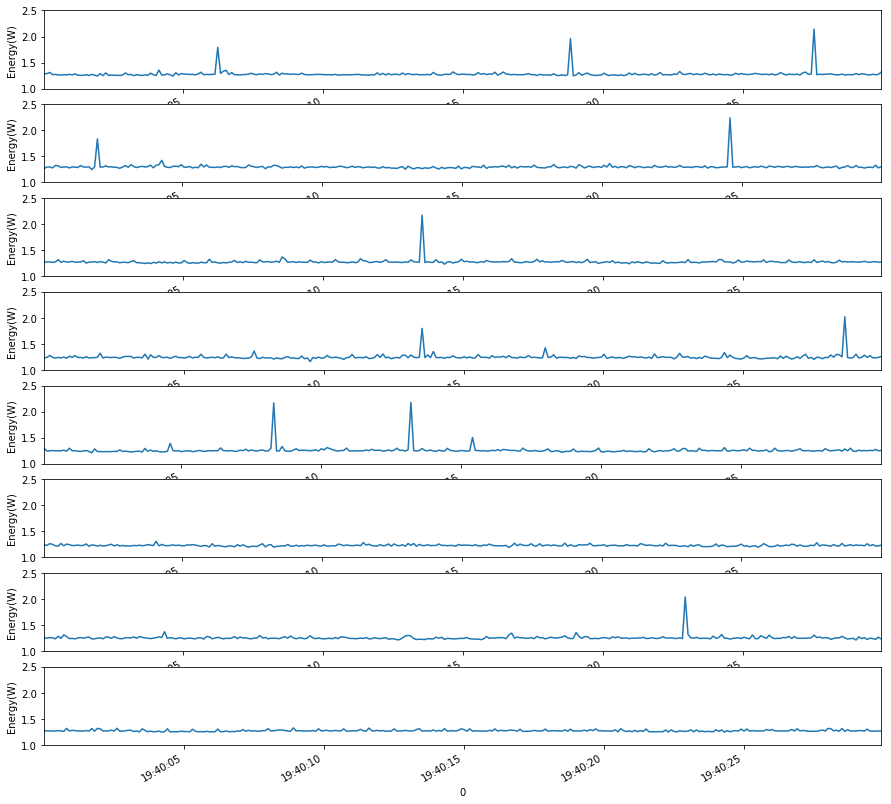

In [111]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation

arr = read_channels('../raw_data/20190226/mesh_clean_2_monitor', plot=False)
arr_clip = clip_channels(arr, startTime='2019-02-26 19:40:00', endTime='2019-02-26 19:40:30', plot=True, ylim=[1.0,2.5])

dataset = arr_clip

[[ 1.         -0.03741315 -0.0369338   0.01516364  0.06757531  0.00480871
   0.00520474  0.03119076]
 [-0.03741315  1.          0.0620419  -0.02110741  0.00763577  0.04686121
   0.01165537  0.02836002]
 [-0.0369338   0.0620419   1.         -0.01622838 -0.01311082 -0.01620031
   0.00583593 -0.05394209]
 [ 0.01516364 -0.02110741 -0.01622838  1.         -0.00396891 -0.02396256
   0.03891962  0.04633917]
 [ 0.06757531  0.00763577 -0.01311082 -0.00396891  1.         -0.02300901
  -0.00799955  0.01946557]
 [ 0.00480871  0.04686121 -0.01620031 -0.02396256 -0.02300901  1.
   0.00729258 -0.00536976]
 [ 0.00520474  0.01165537  0.00583593  0.03891962 -0.00799955  0.00729258
   1.          0.04448408]
 [ 0.03119076  0.02836002 -0.05394209  0.04633917  0.01946557 -0.00536976
   0.04448408  1.        ]]


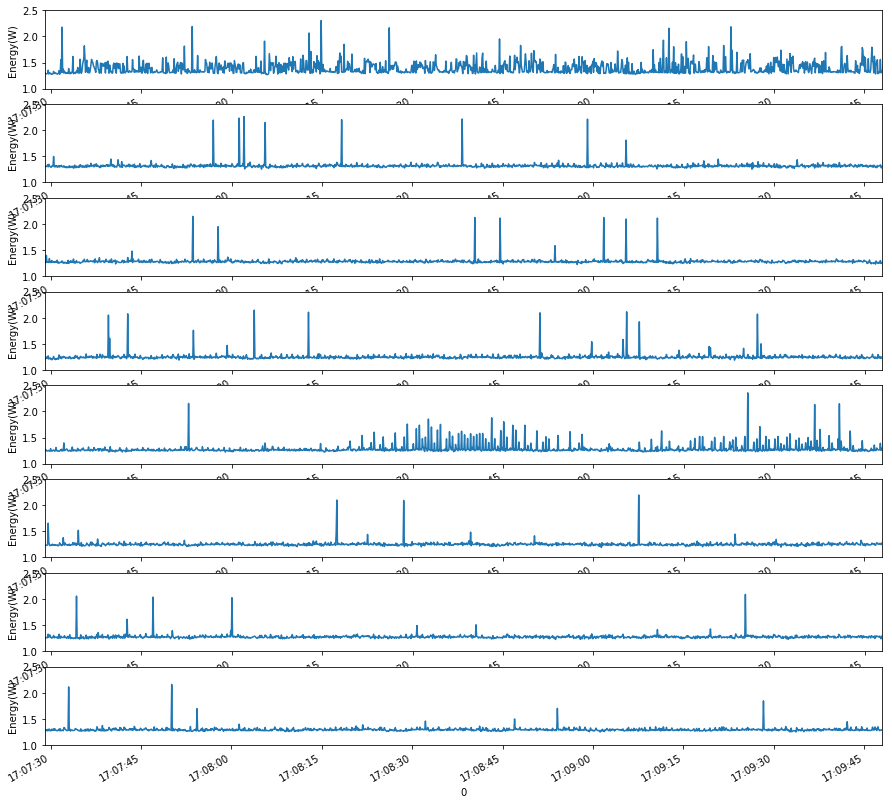

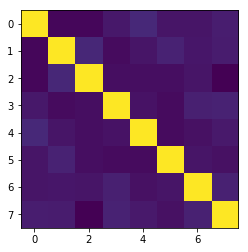

In [50]:
#scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
#dataset = scaler.fit_transform(arr_clip)
attack_arr = read_channels('../raw_data/20190227/ping_attack01_monitor', plot=False)
attack_clip = clip_channels(attack_arr, startTime='2019-02-27 17:07:29',
                endTime='2019-02-27 17:09:48', plot=True, ylim=[1.0,2.5])
dataset = attack_clip
covariance_matrix(np.transpose(dataset), print_matrix=True)

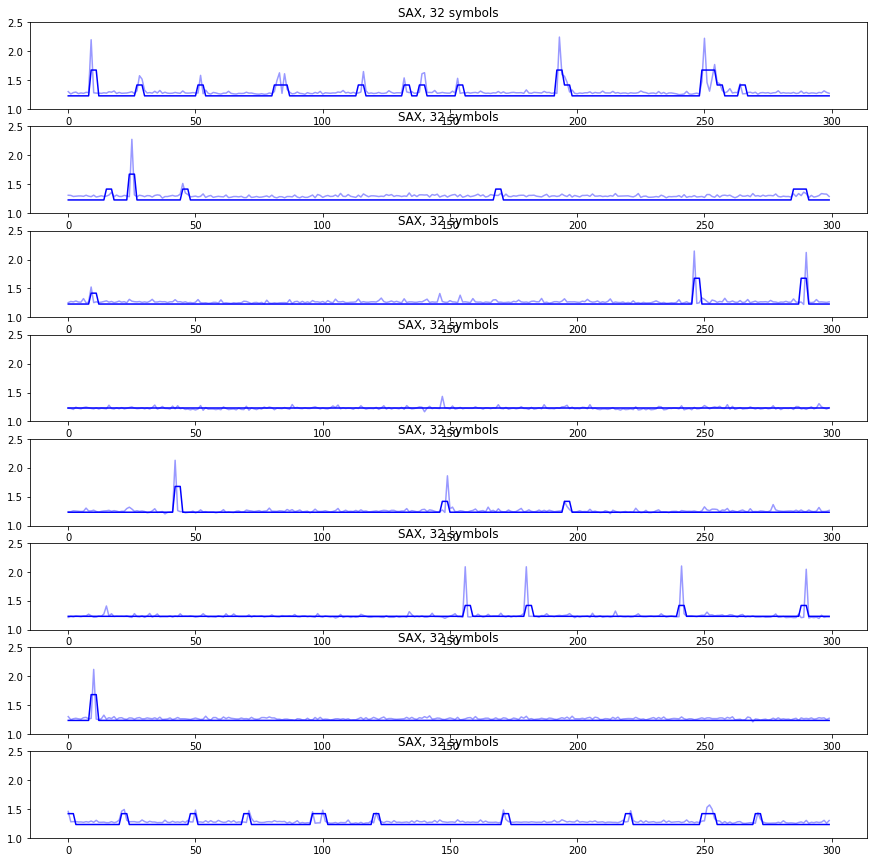

In [116]:
#scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
#dataset = scaler.fit_transform(arr_clip)

# SAX transform
n_paa_segments = 100
n_sax_symbols = 32
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)

sax_arr = []
plt.figure(figsize=(15, 15))
for i in range(len(dataset)):
    sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset[i]))
    plt.subplot(8, 1, i+1)  # Then SAX
    plt.plot(dataset[i].ravel(), "b-", alpha=0.4)
    plt.plot(sax_dataset_inv[0].ravel(), "b-")
    sax_arr.append(sax_dataset_inv[0][:,0])
    plt.ylim([1.0,2.5])
    plt.title("SAX, %d symbols" % n_sax_symbols)
    

In [117]:
from tslearn.metrics import dtw, cdist_dtw

d1=cdist_dtw(sax_arr, sax_arr)
#cdist_dtw([[1,1,1,1,1,2,1,1],[1,1,2,1,1,1,1,1]])

In [118]:
from numpy import linalg as LA
print(LA.norm(d1), LA.norm(d2))

7.43073302371202 5.11822282630187


In [113]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(C=1, loss="hinge", max_iter=5000)

svm_clf.fit(training_X, training_y)
svm_clf.score(testing_X, testing_y)

0.8222222222222222

In [61]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=17)
tree_reg.fit(training_X, training_y)
tree_reg.score(testing_X, testing_y)

0.658431254269104

In [158]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(max_leaf_nodes=500, n_estimators=300, n_jobs=-1)
rnd_clf.fit(training_X, training_y)
rnd_clf.score(testing_X, testing_y)

0.9396825396825397

In [136]:
from sklearn.svm import SVC

svc = SVC(kernel="rbf", C=10, gamma=10, max_iter=2000)

svc.fit(training_X, training_y)
svc.score(testing_X, testing_y)

0.8359788359788359

In [156]:
# Grid Search for fine-tunning the parameters
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_leaf_nodes': [300,400,500,600,700], 'n_estimators':[200,300,400,500,600]},
]

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, 
                          scoring='neg_mean_squared_error')

grid_search.fit(training_X, training_y)
grid_search.best_params_
# grid_search.cv_results_

{'max_leaf_nodes': 400, 'n_estimators': 400}

In [14]:
# autoencoder input
ae_input=[]
ae_output=[]
len_size=10*40
length = len(arr_clip[0])
for i in range(0, length-len_size, 10):
    for j in range(8):
        ae_input.append(arr_matrix[(i):(i+len_size),j])
        ae_input_nopeaks, n_peaks=remove_peaks(np.array(arr_matrix[(i):(i+len_size),j]), threshold=1.4, plot=False)
        ae_output.append(ae_input_nopeaks)

In [164]:
import subprocess
import time

while True:
    subprocess.call(['./real_time_recv.sh'])
    arr = read_channels('../raw_data/realtime/latest_monitor', plot=False, ylim=[1.0,2.5])
    arr_matrix = stack_channels(arr)
    test_eig = [pca_eigenvalues(arr_matrix)[0]]

    rnd_clf_result=log_reg.predict(test_eig)
    print(rnd_clf_result)
    subprocess.call(['./real_time_send.sh', str(int(rnd_clf_result)), str(1-rnd_clf_result[0]), str(rnd_clf_result[0])])
    time.sleep(1)

[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


KeyboardInterrupt: 

In [44]:
import tensorflow as tf

tf.reset_default_graph() 

n_inputs = 400
n_hidden = 400
n_outputs = n_inputs
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X_noisy, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [45]:
X_train, X_train_noisy = np.array(ae_output[0:100]), np.array(ae_input[0:100])

n_iterations = 10000

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train, X_noisy: X_train_noisy})
        if iteration % 500 == 0:
            mse = reconstruction_loss.eval(feed_dict={X: X_train, X_noisy: X_train_noisy})
            print(iteration, "\tMSE:", mse)
    output_eval = outputs.eval(feed_dict={X_noisy: X_train_noisy})

0 	MSE: 29.864565
500 	MSE: 0.0009780708
1000 	MSE: 0.0008933692
1500 	MSE: 0.00080574246
2000 	MSE: 0.00071342
2500 	MSE: 0.0006177847
3000 	MSE: 0.0005274137
3500 	MSE: 19321.193
4000 	MSE: 0.0007528271
4500 	MSE: 0.0007400797
5000 	MSE: 0.00072548055
5500 	MSE: 0.0007092475
6000 	MSE: 0.00069176476
6500 	MSE: 0.00067359145
7000 	MSE: 0.00065531826
7500 	MSE: 0.0006100797
8000 	MSE: 0.0006002153
8500 	MSE: 9.550321
9000 	MSE: 0.00056326494
9500 	MSE: 0.0005529301


In [46]:
print(output_eval.shape)

(100, 400)


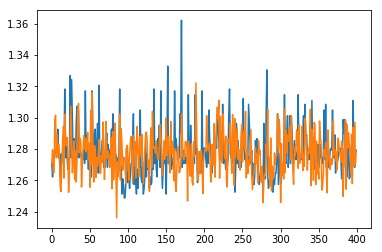

In [48]:
plt.plot(X_train[0])
plt.plot(output_eval[0])